# Cellular Reprogramming

## Imports

In [2]:
# Classic python
import pandas as pd
import numpy as np
from copy import deepcopy
import copy
import os
import sys
from importlib import reload
from scipy.stats import zscore
from scipy.stats import entropy
import scipy.io
import scipy
import textwrap
from scipy import sparse
import importlib
from itertools import product
import pickle
from sklearn.metrics import mean_squared_error
import anndata as ad
import pickle

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3
import matplotlib.ticker as ticker
# import umap

from src import bioObsv

from nb_util import *

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

## Visualize Reprogramming Signal

In [9]:
""" get marker genes """

def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]        
    return genes['official gene symbol'].to_list()

""" Load the marker gene database """
pdfPath = "/nfs/turbo/umms-indikar/shared/projects/public_data/panglao_db/PanglaoDB_markers_27_Mar_2020.tsv.gz"
pang_df = pd.read_csv(pdfPath, sep="\t")
pang_df.head()

""" UI """
U = 0.05

# xtract gene lists    
fbList = getGenes(pang_df, 'Fibroblasts', ui_upper=U)

mg_cells = ['Myoblasts', 'Myofibroblasts', 'Myocytes', 'Cardiomyocytes', 'Myoepithelial cells', 'Myofibroblasts', 'Airway smooth muscle cells']
myList = []

for mg in mg_cells:
    myList += getGenes(pang_df, mg, ui_upper=U)

myogenicGenes = list(set(myList))

In [12]:
# genes from hsa04110 (KEGG Cell Cycle)
cellCycleGenes = ['CCND1', 'CCND2', 'CCND3', 'CDK4', 'CDK6', 'RB1', 'RBL1', 'RBL2', 'ABL1', 'HDAC1', 'HDAC2', 'E2F1', 'E2F2',
                  'E2F3', 'E2F4', 'E2F5', 'TFDP1', 'TFDP2', 'GSK3B', 'TGFB1', 'TGFB2', 'TGFB3', 'SMAD2', 'SMAD3', 'SMAD4', 'MYC',
                  'ZBTB17', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDKN1B', 'CDKN1C', 'CDKN1A', 'CCNE1', 'CCNE2', 'CDK2', 'SKP1',
                  'CUL1', 'RBX1', 'SKP2', 'CCNA2', 'CCNA1', 'CDC6', 'CDT1', 'ORC1', 'ORC2', 'ORC3', 'ORC4', 'ORC5', 'ORC6', 'MCM2',
                  'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7', 'CDC45', 'TICRR', 'MTBP', 'CDC7', 'DBF4', 'DBF4B', 'CDK1', 'CCNB1', 'CCNB2',
                  'CCNB3', 'CDC25B', 'CDC25C', 'YWHAZ', 'YWHAB', 'YWHAQ', 'YWHAE', 'YWHAH', 'YWHAG', 'PLK1', 'WEE1', 'WEE2', 'PKMYT1',
                  'CCNH', 'CDK7', 'ANAPC1', 'ANAPC2', 'CDC27', 'ANAPC4', 'ANAPC5', 'CDC16', 'ANAPC7', 'CDC23', 'ANAPC10', 'ANAPC11',
                  'CDC26', 'ANAPC13', 'ANAPC15', 'ANAPC16', 'CDC20', 'PTTG1', 'PTTG2', 'ESPL1', 'SMC1A', 'SMC1B', 'SMC3', 'RAD21',
                  'STAG2', 'STAG1', 'ATRX', 'DDX11', 'NIPBL', 'MAU2', 'HDAC8', 'ESCO1', 'ESCO2', 'PDS5A', 'PDS5B', 'WAPL', 'CDCA5',
                  'AURKB', 'SGO1', 'PPP2CA', 'PPP2CB', 'PPP2R1B', 'PPP2R1A', 'PPP2R5B', 'PPP2R5C', 'PPP2R5D', 'PPP2R5E', 'PPP2R5A',
                  'NDC80', 'KNL1', 'TTK', 'MAD1L1', 'MAD2L1', 'MAD2L2', 'BUB1B', 'BUB3', 'BUB1', 'TRIP13', 'MAD2L1BP', 'FZR1', 'FBXO5',
                  'CDC14B', 'CDC14A', 'CREBBP', 'EP300', 'PRKDC', 'ATR', 'ATM', 'MDM2', 'TP53', 'GADD45A', 'GADD45B', 'GADD45G',
                  'PCNA', 'SFN', 'CHEK1', 'CHEK2', 'CDC25A', 'GEM', 'CDT1', 'PCNA']
literatureGenes = ['TNNI1', 'MYLPF', 'ACTN2', 'TNNT3', 'CLOCK', 'MYOD1', 'PAX3', 'PAX7', 'MYF5', 'MYOD', 'MYOG', 'MRF4']
coopersEmail = ['NPPA', 'CDH15', 'PYGM', 'MSTN', 'ACTA1', 'TNNC2', 'TMOD4', 'LAMA2', 'ITGA7', 'MYL1', 'PRKCQ', 'MUSK', 'IL4', 'MYH7',
                'PTGIR', 'CAV3', 'MYOD1', 'FGFR4', 'PAX3', 'POPDC2', 'MYOG', 'NPHS1', 'GATA5', 'LDB3', 'NID2', 'TNNT3', 'MYH4', 'GATA4',
                'PDZRN3', 'MEF2D', 'TNNI2', 'ZBTB16', 'TNNI1', 'SIX4', 'PLD1', 'NPPB', 'ANKRD2', 'NGF', 'ANGPT2', 'TTN', 'MEF2B', 'DLL1',
                'THBS4', 'LIF', 'CMKLR1', 'DOCK5', 'CHODL', 'CKM', 'MYLPF', 'ACTN2', 'NEB', 'ANKRD1', 'TCAP', 'MYOZ1', 'MYH8', 'TNNC1', 'MYF6',
                'ADAM12', 'ACTN3', 'MYH1', 'IL1R1', 'FAP', 'ABI3', 'TREML4', 'CD300E', 'SERPINB10', 'TBX18', 'GJB2', 'SLC6A13', 'SCARA5', 'PAMR1',
                'TNXB', 'WIF1', 'ARAP1', 'DKK1', 'PCSK6', 'CXCL3', 'IL6', 'COL13A1', 'ADAMTS10', 'CCL11', 'ADAM33', 'COL4A3', 'COL4A4', 'LAMA2',
                'FBLN7', 'FIBIN', 'NOV', 'MMP3', 'LRRK1', 'HGF', 'COL7A1', 'MEOX1', 'PRG4', 'CCL19', 'FOXF1', 'HAS1', 'WISP1', 'HHIP', 'NT5E',
                'NOX4', 'EN1', 'NFATC1', 'MEDAG', 'TBX20', 'NGF', 'FGF2']
additionalCC = ['MCM5','CCNA2','YWHAB','HDAC1','YWHAH','TGFB2','YWHAQ','TGFB1','FZR1','MCM3','PTTG2','EP300','CDC16','ANAPC5','ANAPC1','CCNB3',
                'MCM2','SMAD4','RB1','YWHAZ','CDK2','ANAPC10','ABL1','WEE1','ANAPC2','MDM2','CDC14B','CDK7','HDAC2','MCM7','CCNE1','SMAD3',
                'CDC26','DBF4','CDKN1B','CUL1','CCND1','SMAD2','PKMYT1','BUB3','E2F3','BUB1B','ANAPC4','CDC7','CCNA1','TGFB3','MAD1L1','SKP1',
                'CDC20','GSK3B','CDC25A','CDKN2B','CDK6','CCNB1','MCM4','CDC27','CDKN1C','YWHAG','MCM6','TP53','BUB1','CCNH','ANAPC11','E2F1',
                'ESPL1','CDC25C','GADD45A','TFDP1','ATM','CDC25B','SMC1B','GADD45G','CDK4','PLK1','CCNB2','SKP2','GADD45B','PCNA','E2F2','CCND3',
                'ATR','CDKN2A','CDKN2D','RBX1','MAD2L2','SMC1A','CCNE2','CDKN1A','PTTG1','SFN','YWHAE','CCND2','CDC23','CDKN2C','CHEK2','CHEK1',
                'CREBBP','RBL2','PRKDC','MAD2L1','RBL1','CDC6','ANAPC7','CDC14A', 'OCT3' 'OCT4', 'SOX2', 'KLF4', 'MYC', 'CMYC', 'OCT3/4']
cellCycleGenes += additionalCC
subsetGenes = list(set(myogenicGenes + cellCycleGenes + literatureGenes + coopersEmail))
len(subsetGenes)

419

In [13]:
ccGenesOnline = {"attribute":{"name":"cell cycle","href":"/api/1.0/attribute/cell+cycle"},"dataset":{"name":"KEGG Pathways","href":"/api/1.0/dataset/KEGG+Pathways"},
                 "associations":[{"gene":{"symbol":"MCM5","href":"/api/1.0/gene/MCM5"},"thresholdValue":1.0},{"gene":{"symbol":"CCNA2","href":"/api/1.0/gene/CCNA2"},
                 "thresholdValue":1.0},{"gene":{"symbol":"YWHAB","href":"/api/1.0/gene/YWHAB"},"thresholdValue":1.0},{"gene":{"symbol":"HDAC1","href":"/api/1.0/gene/HDAC1"},
                 "thresholdValue":1.0},{"gene":{"symbol":"YWHAH","href":"/api/1.0/gene/YWHAH"},"thresholdValue":1.0},{"gene":{"symbol":"TGFB2","href":"/api/1.0/gene/TGFB2"},
                 "thresholdValue":1.0},{"gene":{"symbol":"YWHAQ","href":"/api/1.0/gene/YWHAQ"},"thresholdValue":1.0},{"gene":{"symbol":"TGFB1","href":"/api/1.0/gene/TGFB1"},
                 "thresholdValue":1.0},{"gene":{"symbol":"FZR1","href":"/api/1.0/gene/FZR1"},"thresholdValue":1.0},{"gene":{"symbol":"MCM3","href":"/api/1.0/gene/MCM3"},
                 "thresholdValue":1.0},{"gene":{"symbol":"PTTG2","href":"/api/1.0/gene/PTTG2"},"thresholdValue":1.0},{"gene":{"symbol":"EP300","href":"/api/1.0/gene/EP300"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CDC16","href":"/api/1.0/gene/CDC16"},"thresholdValue":1.0},{"gene":{"symbol":"ANAPC5","href":"/api/1.0/gene/ANAPC5"},
                 "thresholdValue":1.0},{"gene":{"symbol":"ANAPC1","href":"/api/1.0/gene/ANAPC1"},"thresholdValue":1.0},{"gene":{"symbol":"CCNB3","href":"/api/1.0/gene/CCNB3"},
                 "thresholdValue":1.0},{"gene":{"symbol":"MCM2","href":"/api/1.0/gene/MCM2"},"thresholdValue":1.0},{"gene":{"symbol":"SMAD4","href":"/api/1.0/gene/SMAD4"},
                 "thresholdValue":1.0},{"gene":{"symbol":"RB1","href":"/api/1.0/gene/RB1"},"thresholdValue":1.0},{"gene":{"symbol":"YWHAZ","href":"/api/1.0/gene/YWHAZ"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CDK2","href":"/api/1.0/gene/CDK2"},"thresholdValue":1.0},{"gene":{"symbol":"ANAPC10","href":"/api/1.0/gene/ANAPC10"},
                 "thresholdValue":1.0},{"gene":{"symbol":"ABL1","href":"/api/1.0/gene/ABL1"},"thresholdValue":1.0},{"gene":{"symbol":"WEE1","href":"/api/1.0/gene/WEE1"},
                 "thresholdValue":1.0},{"gene":{"symbol":"ANAPC2","href":"/api/1.0/gene/ANAPC2"},"thresholdValue":1.0},{"gene":{"symbol":"MDM2","href":"/api/1.0/gene/MDM2"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CDC14B","href":"/api/1.0/gene/CDC14B"},"thresholdValue":1.0},{"gene":{"symbol":"CDK7","href":"/api/1.0/gene/CDK7"},
                 "thresholdValue":1.0},{"gene":{"symbol":"HDAC2","href":"/api/1.0/gene/HDAC2"},"thresholdValue":1.0},{"gene":{"symbol":"MCM7","href":"/api/1.0/gene/MCM7"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CCNE1","href":"/api/1.0/gene/CCNE1"},"thresholdValue":1.0},{"gene":{"symbol":"SMAD3","href":"/api/1.0/gene/SMAD3"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CDC26","href":"/api/1.0/gene/CDC26"},"thresholdValue":1.0},{"gene":{"symbol":"DBF4","href":"/api/1.0/gene/DBF4"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CDKN1B","href":"/api/1.0/gene/CDKN1B"},"thresholdValue":1.0},{"gene":{"symbol":"CUL1","href":"/api/1.0/gene/CUL1"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CCND1","href":"/api/1.0/gene/CCND1"},"thresholdValue":1.0},{"gene":{"symbol":"SMAD2","href":"/api/1.0/gene/SMAD2"},
                 "thresholdValue":1.0},{"gene":{"symbol":"PKMYT1","href":"/api/1.0/gene/PKMYT1"},"thresholdValue":1.0},{"gene":{"symbol":"BUB3","href":"/api/1.0/gene/BUB3"},
                 "thresholdValue":1.0},{"gene":{"symbol":"E2F3","href":"/api/1.0/gene/E2F3"},"thresholdValue":1.0},{"gene":{"symbol":"BUB1B","href":"/api/1.0/gene/BUB1B"},
                 "thresholdValue":1.0},{"gene":{"symbol":"ANAPC4","href":"/api/1.0/gene/ANAPC4"},
                "thresholdValue":1.0},{"gene":{"symbol":"CDC7","href":"/api/1.0/gene/CDC7"},"thresholdValue":1.0},{"gene":{"symbol":"CCNA1","href":"/api/1.0/gene/CCNA1"},"thresholdValue":1.0},
                {"gene":{"symbol":"TGFB3","href":"/api/1.0/gene/TGFB3"},"thresholdValue":1.0},{"gene":{"symbol":"MAD1L1","href":"/api/1.0/gene/MAD1L1"},"thresholdValue":1.0},
                {"gene":{"symbol":"SKP1","href":"/api/1.0/gene/SKP1"},
                 "thresholdValue":1.0},{"gene":{"symbol":"CDC20","href":"/api/1.0/gene/CDC20"},"thresholdValue":1.0},{"gene":{"symbol":"GSK3B","href":"/api/1.0/gene/GSK3B"},"thresholdValue":1.0},{"gene":{"symbol":"CDC25A","href":"/api/1.0/gene/CDC25A"},"thresholdValue":1.0},{"gene":{"symbol":"CDKN2B","href":"/api/1.0/gene/CDKN2B"},"thresholdValue":1.0},{"gene":{"symbol":"CDK6","href":"/api/1.0/gene/CDK6"},"thresholdValue":1.0},{"gene":{"symbol":"CCNB1","href":"/api/1.0/gene/CCNB1"},"thresholdValue":1.0},{"gene":{"symbol":"MCM4","href":"/api/1.0/gene/MCM4"},"thresholdValue":1.0},{"gene":{"symbol":"CDC27","href":"/api/1.0/gene/CDC27"},"thresholdValue":1.0},{"gene":{"symbol":"CDKN1C","href":"/api/1.0/gene/CDKN1C"},"thresholdValue":1.0},{"gene":{"symbol":"YWHAG","href":"/api/1.0/gene/YWHAG"},
                 "thresholdValue":1.0},{"gene":{"symbol":"MCM6","href":"/api/1.0/gene/MCM6"},"thresholdValue":1.0},{"gene":{"symbol":"TP53","href":"/api/1.0/gene/TP53"},"thresholdValue":1.0},{"gene":{"symbol":"BUB1","href":"/api/1.0/gene/BUB1"},"thresholdValue":1.0},{"gene":{"symbol":"CCNH","href":"/api/1.0/gene/CCNH"},"thresholdValue":1.0},{"gene":{"symbol":"ANAPC11","href":"/api/1.0/gene/ANAPC11"},"thresholdValue":1.0},{"gene":{"symbol":"E2F1","href":"/api/1.0/gene/E2F1"},"thresholdValue":1.0},{"gene":{"symbol":"ESPL1","href":"/api/1.0/gene/ESPL1"},"thresholdValue":1.0},{"gene":{"symbol":"CDC25C","href":"/api/1.0/gene/CDC25C"},
                "thresholdValue":1.0},{"gene":{"symbol":"GADD45A","href":"/api/1.0/gene/GADD45A"},"thresholdValue":1.0},{"gene":{"symbol":"TFDP1","href":"/api/1.0/gene/TFDP1"},
                 "thresholdValue":1.0},{"gene":{"symbol":"ATM","href":"/api/1.0/gene/ATM"},"thresholdValue":1.0},{"gene":{"symbol":"CDC25B","href":"/api/1.0/gene/CDC25B"},"thresholdValue":1.0},{"gene":{"symbol":"SMC1B","href":"/api/1.0/gene/SMC1B"},"thresholdValue":1.0},{"gene":{"symbol":"GADD45G","href":"/api/1.0/gene/GADD45G"},"thresholdValue":1.0},{"gene":{"symbol":"CDK4","href":"/api/1.0/gene/CDK4"},"thresholdValue":1.0},{"gene":{"symbol":"PLK1","href":"/api/1.0/gene/PLK1"},"thresholdValue":1.0},{"gene":{"symbol":"CCNB2","href":"/api/1.0/gene/CCNB2"},"thresholdValue":1.0},{"gene":{"symbol":"SKP2","href":"/api/1.0/gene/SKP2"},
                "thresholdValue":1.0},{"gene":{"symbol":"GADD45B","href":"/api/1.0/gene/GADD45B"},"thresholdValue":1.0},{"gene":{"symbol":"PCNA","href":"/api/1.0/gene/PCNA"},"thresholdValue":1.0},{"gene":{"symbol":"E2F2","href":"/api/1.0/gene/E2F2"},"thresholdValue":1.0},{"gene":{"symbol":"CCND3","href":"/api/1.0/gene/CCND3"},"thresholdValue":1.0},{"gene":{"symbol":"ATR","href":"/api/1.0/gene/ATR"},
                "thresholdValue":1.0},{"gene":{"symbol":"CDKN2A","href":"/api/1.0/gene/CDKN2A"},"thresholdValue":1.0},{"gene":{"symbol":"CDKN2D","href":"/api/1.0/gene/CDKN2D"},"thresholdValue":1.0},{"gene":{"symbol":"RBX1","href":"/api/1.0/gene/RBX1"},"thresholdValue":1.0},
                 {"gene":{"symbol":"MAD2L2","href":"/api/1.0/gene/MAD2L2"},"thresholdValue":1.0},{"gene":{"symbol":"SMC1A","href":"/api/1.0/gene/SMC1A"},"thresholdValue":1.0},{"gene":{"symbol":"CCNE2","href":"/api/1.0/gene/CCNE2"},"thresholdValue":1.0},{"gene":{"symbol":"CDKN1A","href":"/api/1.0/gene/CDKN1A"},"thresholdValue":1.0},{"gene":{"symbol":"PTTG1","href":"/api/1.0/gene/PTTG1"},"thresholdValue":1.0},{"gene":{"symbol":"SFN","href":"/api/1.0/gene/SFN"},"thresholdValue":1.0},{"gene":{"symbol":"YWHAE","href":"/api/1.0/gene/YWHAE"},"thresholdValue":1.0},{"gene":{"symbol":"CCND2","href":"/api/1.0/gene/CCND2"},"thresholdValue":1.0},{"gene":{"symbol":"CDC23","href":"/api/1.0/gene/CDC23"},"thresholdValue":1.0},{"gene":{"symbol":"CDKN2C","href":"/api/1.0/gene/CDKN2C"},"thresholdValue":1.0},{"gene":{"symbol":"CHEK2","href":"/api/1.0/gene/CHEK2"},"thresholdValue":1.0},{"gene":{"symbol":"CHEK1","href":"/api/1.0/gene/CHEK1"},"thresholdValue":1.0},{"gene":{"symbol":"CREBBP","href":"/api/1.0/gene/CREBBP"},"thresholdValue":1.0},{"gene":{"symbol":"RBL2","href":"/api/1.0/gene/RBL2"},"thresholdValue":1.0},{"gene":{"symbol":"PRKDC","href":"/api/1.0/gene/PRKDC"},"thresholdValue":1.0},{"gene":{"symbol":"MAD2L1","href":"/api/1.0/gene/MAD2L1"},"thresholdValue":1.0},{"gene":{"symbol":"RBL1","href":"/api/1.0/gene/RBL1"},"thresholdValue":1.0},{"gene":{"symbol":"CDC6","href":"/api/1.0/gene/CDC6"},"thresholdValue":1.0},{"gene":{"symbol":"ANAPC7","href":"/api/1.0/gene/ANAPC7"},"thresholdValue":1.0},{"gene":{"symbol":"CDC14A","href":"/api/1.0/gene/CDC14A"},"thresholdValue":1.0}]}
for assot in ccGenesOnline['associations']:
    print(assot['gene']['symbol'], end="','")

MCM5','CCNA2','YWHAB','HDAC1','YWHAH','TGFB2','YWHAQ','TGFB1','FZR1','MCM3','PTTG2','EP300','CDC16','ANAPC5','ANAPC1','CCNB3','MCM2','SMAD4','RB1','YWHAZ','CDK2','ANAPC10','ABL1','WEE1','ANAPC2','MDM2','CDC14B','CDK7','HDAC2','MCM7','CCNE1','SMAD3','CDC26','DBF4','CDKN1B','CUL1','CCND1','SMAD2','PKMYT1','BUB3','E2F3','BUB1B','ANAPC4','CDC7','CCNA1','TGFB3','MAD1L1','SKP1','CDC20','GSK3B','CDC25A','CDKN2B','CDK6','CCNB1','MCM4','CDC27','CDKN1C','YWHAG','MCM6','TP53','BUB1','CCNH','ANAPC11','E2F1','ESPL1','CDC25C','GADD45A','TFDP1','ATM','CDC25B','SMC1B','GADD45G','CDK4','PLK1','CCNB2','SKP2','GADD45B','PCNA','E2F2','CCND3','ATR','CDKN2A','CDKN2D','RBX1','MAD2L2','SMC1A','CCNE2','CDKN1A','PTTG1','SFN','YWHAE','CCND2','CDC23','CDKN2C','CHEK2','CHEK1','CREBBP','RBL2','PRKDC','MAD2L1','RBL1','CDC6','ANAPC7','CDC14A','

In [23]:
datafile = '/nfs/turbo/umms-indikar/Joshua/bioObsv/notebooks/obsvArticle/dataProcessing/2018_data.pkl'
with open(datafile, 'rb') as file:
    full2018 = pickle.load(file)

full2018['TPM'] = full2018['tpm']
print(f"{full2018['TPM'].shape=}")
print(f"{full2018.keys()=}")


full2018['TPM'].shape=(19235, 15, 3)
full2018.keys()=dict_keys(['replicates', 'tpm', 'fc', 'TPM'])


In [24]:
datafile = '/nfs/turbo/umms-indikar/shared/projects/public_data/time_series_RNA/cellular-reprogramming-2018/reduced2018.pkl'
with open(datafile, 'rb') as file:
    reduced2018 = pickle.load(file)

print(f"{reduced2018['TPM'].shape=}")
print(f"{reduced2018.keys()=}")

GENES = reduced2018['genes']

reduced2018['TPM'].shape=(406, 15, 3)
reduced2018.keys()=dict_keys(['TPM', 'FC', 'genes'])


In [46]:
ccIdxs = [reduced2018['genes'].index(gene) for gene in cellCycleGenes if gene in reduced2018['genes']]
ccTPM = reduced2018['TPM'][ccIdxs,:,:]
ccSums = np.sum(ccTPM, axis=0)
ccMeans = np.mean(ccSums, axis=1)
ccStd = np.std(ccSums, axis=1)

myogenicIdxs = [keptGenes.index(gene) for gene in myogenicGenes if gene in reduced2018['genes']]
myogenicTPM = reduced2018['TPM'][myogenicIdxs,:,:]
myogenicSums = np.sum(myogenicTPM, axis=0)
myogenicMeans = np.mean(myogenicSums, axis=1)
myogenicStd = np.std(myogenicSums, axis=1)

total_expression_Sums = np.sum(full2018['TPM'], axis=0)
total_expression_mean = np.mean(np.sum(full2018['TPM'], axis=0), axis=1)
total_expression_std = np.std(np.sum(full2018['TPM'], axis=0), axis=1)


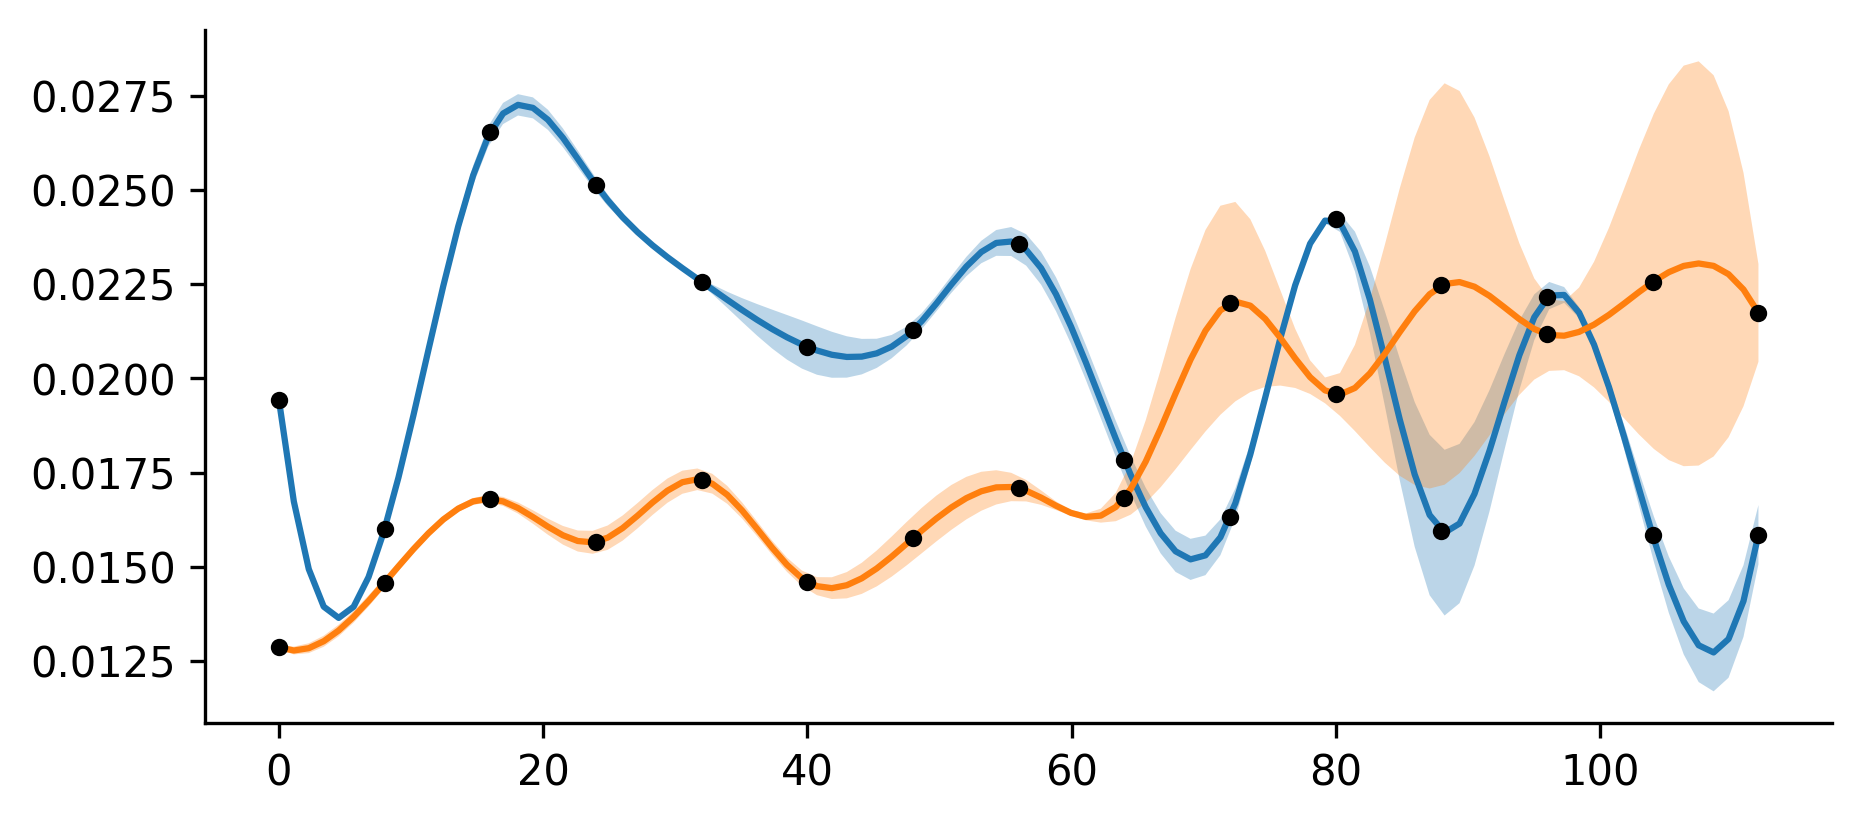

In [51]:
from scipy.interpolate import interp1d

## Cell Cycle Signal
x_values = 8*np.arange(len(ccMeans))
contributedExpression = np.zeros_like(ccSums)
for i in range(15):
    contributedExpression[i,:] = ccSums[i,:] / total_expression_mean[i]
contributedMeans = np.mean(contributedExpression, axis=1)
contributedStd = np.std(contributedExpression, axis=1)
mean_interp = interp1d(x_values, contributedMeans, kind='cubic')
std_interp = interp1d(x_values, contributedStd, kind='cubic')
x_interp = np.linspace(x_values.min(), x_values.max(), 100)
plt.plot(x_interp, mean_interp(x_interp),
                 label='Cell Cycle')
plt.fill_between(x_interp,
                 mean_interp(x_interp) - std_interp(x_interp),
                 mean_interp(x_interp) + std_interp(x_interp),
                 alpha=0.3)
plt.scatter(x_values, contributedMeans, color='black', s=10, zorder=3)


## Myogenic Signal
x_values = 8*np.arange(len(myogenicMeans))
contributedExpression = np.zeros_like(myogenicSums)
for i in range(15):
    contributedExpression[i,:] = myogenicSums[i,:] / total_expression_mean[i]
contributedMeans = np.mean(contributedExpression, axis=1)
contributedStd = np.std(contributedExpression, axis=1)
mean_interp = interp1d(x_values, contributedMeans, kind='cubic')
std_interp = interp1d(x_values, contributedStd, kind='cubic')
x_interp = np.linspace(x_values.min(), x_values.max(), 100)
plt.plot(x_interp, mean_interp(x_interp),
                 label='Myogenic Signal')
plt.fill_between(x_interp,
                 mean_interp(x_interp) - std_interp(x_interp),
                 mean_interp(x_interp) + std_interp(x_interp),
                 alpha=0.3)
plt.scatter(x_values, contributedMeans, color='black', s=10, zorder=3)
sns.despine()

## Build Functional Matrix F

In [3]:
datafile = '/nfs/turbo/umms-indikar/shared/projects/public_data/time_series_RNA/cellular-reprogramming-2018/reduced2018.pkl'
with open(datafile, 'rb') as file:
    reduced2018 = pickle.load(file)

print(f"{reduced2018['TPM'].shape=}")
print(f"{reduced2018.keys()=}")

GENES = reduced2018['genes']

reduced2018['TPM'].shape=(406, 15, 3)
reduced2018.keys()=dict_keys(['TPM', 'FC', 'genes'])


In [3]:
""" get marker genes """

def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]        
    return genes['official gene symbol'].to_list()

""" Load the marker gene database """
pdfPath = "/home/jpic/bioObsv/notebooks/obsvArticle2/data/PanglaoDB_markers_27_Mar_2020.tsv.gz"
pang_df = pd.read_csv(pdfPath, sep="\t")
pang_df.head()

""" UI """
U = 0.05

# xtract gene lists    
fbList = getGenes(pang_df, 'Fibroblasts', ui_upper=U)

mg_cells = ['Myoblasts', 'Myofibroblasts', 'Myocytes', 'Cardiomyocytes', 'Myoepithelial cells', 'Myofibroblasts', 'Airway smooth muscle cells']
myList = []

for mg in mg_cells:
    myList += getGenes(pang_df, mg, ui_upper=U)

myogenicGenes = list(set(myList))
print(f"{len(myogenicGenes)=}")

cellCycleF = np.zeros(len(GENES),)
reprogramF = np.zeros(len(GENES),)
cellCycleGenes = []
for i, gene in enumerate(GENES):
    if gene in myogenicGenes:
        reprogramF[i] = 1
    else:
        cellCycleF[i] = 1
        cellCycleGenes.append(gene)

print(f"{sum(cellCycleF)=}")
print(f"{sum(reprogramF)=}")

F = np.vstack((reprogramF, cellCycleF))
print(f"{F.shape=}")

print(f"{len(cellCycleGenes)=}")
print(f"{len(myogenicGenes)=}")


len(myogenicGenes)=212
sum(cellCycleF)=200.0
sum(reprogramF)=206.0
F.shape=(2, 406)
len(cellCycleGenes)=200
len(myogenicGenes)=212


## Load time series data and biomarkers

In [28]:
X = reduced2018['TPM']
print(f"{X.shape=}")
REDUCEDGENES = reduced2018['genes']
print(f"{len(REDUCEDGENES)=}")

Xavg = np.mean(X, axis=2)
print(f"{Xavg.shape=}")

sensors = {}
for i in range(X.shape[1]):
    idx = list(np.argsort(Xavg[:,i]))
    idx.reverse()
    idx = idx[:200]
    sensorGenes = [REDUCEDGENES[i] for i in idx]
    sensors[i] = sensorGenes

sdf = pd.DataFrame(sensors)
sdf

X.shape=(406, 15, 3)
len(REDUCEDGENES)=406
Xavg.shape=(406, 15)


0       1       2        3       4       5       6      7       8   \
0     ACTC1    STC1   ACTC1    ACTC1    STC1   TAGLN   TAGLN   DKK1   CXCL1   
1      DKK1    MMP3    DKK1    TAGLN    DKK1  CDKN1A   ACTC1  ACTC1    CCL2   
2     CCND1  CDKN1A   TAGLN    CCND1  CDKN1A     ADM    DKK1  TAGLN     ADM   
3    CDKN1A   CCND1   CCND1     DKK1   ACTC1    MMP3    MMP3  CCND1    MMP3   
4     TAGLN     LOX  CDKN1A     STC1   TAGLN   ACTC1   CCND1    ADM  CDKN1A   
..      ...     ...     ...      ...     ...     ...     ...    ...     ...   
195   ITGA7  PPP2CA    BMP4      HGF  ANAPC4  PPP2CA   ACTG2  ARAP1   LAMA2   
196    KNL1    ORC2   NIPBL     E2F3    ORC2   TNNT2   SGPL1   CDK7  TRIP13   
197   NDC80    AQP1   CDC45     ORC1    E2F2    DBF4    E2F2  CCNE1    NPPA   
198    E2F3   ESCO1   ACTG2    MYOZ1    CDK7    CDK7  PDZRN3   ATRX   ESCO1   
199   CCND3   ITGA7     ATR  PPP2R5A    CCNH   DOCK5     HGF   SGO1     ATR   

         9       10      11     12      13      14  
0     CXCL1  CDKN1A   CXCL1  CXCL1   CXCL1    MMP3  
1      CCL2    CCL2    CCL2   CCL2    CCL2   CXCL1  
2      MMP3     ADM    MMP3   STC1     ADM     ADM  
3       ADM   CXCL1     ADM    ADM    MMP3    CCL2  
4      STC1    STC1    STC1    GEM    STC1    DKK1  
..      ...     ...     ...    ...     ...     ...  
195  PPP2CA    CDK7   GSK3B  HAND2   ESPL1  CDC14B  
196    DLL1  CDKN2A  CDC14B  TXLNB    CCNH   ESCO1  
197   NIPBL   STAG2  PDLIM5   DBF4  CDC14B  PPP2CA  
198   CPT1A    E2F5     ATR   CDK7    STRN    CDK7  
199   TNNT1   LAMA2    DLL1   BDNF   FGFR4    PLK1  

[200 rows x 15 columns]

In [29]:
datafile = '/nfs/turbo/umms-indikar/Joshua/bioObsv/notebooks/obsvArticle/dataProcessing/2018_data.pkl'
with open(datafile, 'rb') as file:
    full2018 = pickle.load(file)

full2018['TPM'] = full2018['tpm']
print(f"{full2018['TPM'].shape=}")
print(f"{full2018.keys()=}")

GENES = list(full2018['replicates']['r1'].index.values)

full2018['TPM'].shape=(19235, 15, 3)
full2018.keys()=dict_keys(['replicates', 'tpm', 'fc', 'TPM'])


In [6]:
# Amit generated these files
#gramianSensorFiles = {
#    'DMD': '/nfs/turbo/umms-indikar/Joshua/bioObsv/notebooks/obsvArticle/dataProcessing/amit/sensorSet_2018mix_raw_full_DMD_repall.xls',
#    'DGC': '/nfs/turbo/umms-indikar/Joshua/bioObsv/notebooks/obsvArticle/dataProcessing/amit/sensorSet_2018mix_raw_full_timeVarying_repall.xls'
#}

## Fixed Sensors but Dynamic Functional Observability

In [32]:
help(bioObsv.Model.LinearTimeVariant)

Help on class LinearTimeVariant in module scr.Model:

class LinearTimeVariant(Model)
 |  LinearTimeVariant(times=None, data=None, states=None, dmdRanks=None, LTIs=None, debug=False, reduced=True, u_r=None)
 |  
 |  Linear Time-Variant (LTV) model class
 |  
 |  Args:
 |      Model (_type_): _description_
 |  
 |  Raises:
 |      ValueError: _description_
 |  
 |  Returns:
 |      _type_: _description_
 |  
 |  Method resolution order:
 |      LinearTimeVariant
 |      Model
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, times=None, data=None, states=None, dmdRanks=None, LTIs=None, debug=False, reduced=True, u_r=None)
 |      _summary_
 |      
 |      Args:
 |          data (ndarray, optional): time series data. Defaults to None.
 |          models (dict, optional): dictionary of models at each time. Defaults to None.
 |          states (list, optional): list of states. Defaults to None.
 |          times (list, optional): list of time ranges where a sin

### Build Model

In [34]:
model = 'DGC'
LTV = bioObsv.Model.LinearTimeVariant(data=full2018['TPM'], states=GENES)

# fixedSensors = 'Sheet2'
# sdf = pd.read_excel(gramianSensorFiles[model], sheet_name=fixedSensors)


In [14]:
sdf = sdf.applymap(lambda x: x.strip() if isinstance(x, str) else x)
sensors = list(sdf.iloc[:200].values)
sensorsFiltered = []
for s in sensors:
    if s[0] in myogenicGenes:
        sensorsFiltered.append(s)
len(sensorsFiltered)
# sensors = list(set(myogenicGenes).intersection(set(sensors)))
LTI.setMeasurments(sensorsFiltered)

 /tmp/ipykernel_2635337/1772870310.py:1: FutureWarning:DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [15]:
sensorsFiltered = []
for s in sensors:
    if s[0] in myogenicGenes:
        sensorsFiltered.append(s)
len(sensorsFiltered)

106

In [16]:
O = LTI.obsv(t=10, reduced=True)
print(f"{O.shape=}")
print(f"{O.shape=}")
O = O / O.sum(axis=1, keepdims=1)
O[np.isnan(O)] = 0
O[np.isinf(O)] = 0
print(f"{O.shape=}")

O.shape=(1060, 19235)
O.shape=(1060, 19235)
O.shape=(1060, 19235)


 /tmp/ipykernel_2635337/3484923492.py:4: RuntimeWarning:divide by zero encountered in divide
 /tmp/ipykernel_2635337/3484923492.py:4: RuntimeWarning:invalid value encountered in divide


In [17]:
O1 = O[:106,:]

In [27]:
from scipy.sparse.linalg import svds

# Set k to the number of largest singular values/vectors you want
k = 10  # adjust k as needed

# Compute the largest k singular values and vectors
U,  Sigma, Vt = svds(O, k=k)
U1, Sigma1, Vt1 = svds(O1, k=k)


In [28]:
masks = np.zeros_like(GENES, dtype=bool)
for i, gene in enumerate(GENES):
    if gene in myogenicGenes:
        masks[i] = True

myoWeights = Vt[:, masks]
myoWeights1 = Vt1[:, masks]
print(f"{myoWeights.shape=}")
print(f"{myoWeights1.shape=}")

masks = np.zeros_like(GENES, dtype=bool)
for i, gene in enumerate(GENES):
    if gene in cellCycleGenes:
        masks[i] = True

ccWeights = Vt[:, masks]
ccWeights1 = Vt1[:, masks]
print(f"{ccWeights.shape=}")
print(f"{ccWeights1.shape=}")


myoWeights = myoWeights # np.log(np.abs(myoWeights))
ccWeights  = ccWeights  # np.log(np.abs(ccWeights))
VtWeights  = Vt         # np.log(np.abs(Vt))
myoWeights1 = myoWeights1 # np.log(np.abs(myoWeights))
ccWeights1  = ccWeights1  # np.log(np.abs(ccWeights))
VtWeights1  = Vt1         # np.log(np.abs(Vt))

myoWeights[np.isnan(myoWeights)] = 0
ccWeights [np.isnan(ccWeights )] = 0
VtWeights [np.isnan(VtWeights )] = 0
myoWeights[np.isinf(myoWeights) | (myoWeights == -np.inf)] = 0
ccWeights [np.isinf(ccWeights) | (ccWeights == -np.inf)] = 0
VtWeights [np.isinf(VtWeights) | (VtWeights == -np.inf)] = 0


myoWeights1[np.isnan(myoWeights1)] = 0
ccWeights1 [np.isnan(ccWeights1 )] = 0
VtWeights1 [np.isnan(VtWeights1 )] = 0
myoWeights1[np.isinf(myoWeights1) | (myoWeights1 == -np.inf)] = 0
ccWeights1 [np.isinf(ccWeights1) | (ccWeights1 == -np.inf)] = 0
VtWeights1 [np.isinf(VtWeights1) | (VtWeights1 == -np.inf)] = 0


myoWeights.shape=(10, 206)
myoWeights1.shape=(10, 206)
ccWeights.shape=(10, 200)
ccWeights1.shape=(10, 200)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Pre-allocate arrays to store means and standard deviations for visualization
num_rows  = 10  # The number of rows you want to visualize
Vt_means  = np.zeros(num_rows)
Vt_stds   = np.zeros(num_rows)
myo_means = np.zeros(num_rows)
myo_stds  = np.zeros(num_rows)
cc_means  = np.zeros(num_rows)
cc_stds   = np.zeros(num_rows)

# Calculate mean and standard deviation for each row in Vt and myoWeights
for i in range(num_rows):
    Vt_means[i] = np.mean(np.abs(VtWeights[i, :]))
    myo_means[i] = np.mean(np.abs(myoWeights[i, :]))
    cc_means[i] = np.mean(np.abs(ccWeights[i, :]))
    Vt_stds[i]  = stats.sem(np.abs(VtWeights[i, :]))
    myo_stds[i] = stats.sem(np.abs(myoWeights[i, :]))
    cc_stds[i]  = stats.sem(np.abs(ccWeights[i, :]))


# Pre-allocate arrays to store means and standard deviations for visualization
num_rows1  = 10  # The number of rows you want to visualize
Vt_means1  = np.zeros(num_rows)
Vt_stds1   = np.zeros(num_rows)
myo_means1 = np.zeros(num_rows)
myo_stds1  = np.zeros(num_rows)
cc_means1  = np.zeros(num_rows)
cc_stds1   = np.zeros(num_rows)

# Calculate mean and standard deviation for each row in Vt and myoWeights
for i in range(num_rows):
    Vt_means1[i] = np.mean(np.abs(VtWeights1[i, :]))
    myo_means1[i] = np.mean(np.abs(myoWeights1[i, :]))
    cc_means1[i] = np.mean(np.abs(ccWeights1[i, :]))
    Vt_stds1[i]  = stats.sem(np.abs(VtWeights1[i, :]))
    myo_stds1[i] = stats.sem(np.abs(myoWeights1[i, :]))
    cc_stds1[i]  = stats.sem(np.abs(ccWeights1[i, :]))

# Create a DataFrame to store all data
data = {
    'Row': [f'Row {i}' for i in range(num_rows)],
    'Vt_means': Vt_means,
    'Vt_serr': Vt_stds,
    'myo_means': myo_means,
    'myo_serr': myo_stds,
    'cc_means': cc_means,
    'cc_serr': cc_stds
}

df = pd.DataFrame(data)
df.to_csv('data/functional_obsv_data-full.csv', index=False)

# Create a DataFrame to store all data
data = {
    'Row': [f'Row {i}' for i in range(num_rows)],
    'Vt_means': Vt_means1,
    'Vt_serr': Vt_stds1,
    'myo_means': myo_means1,
    'myo_serr': myo_stds1,
    'cc_means': cc_means1,
    'cc_serr': cc_stds1
}

df = pd.DataFrame(data)
df.to_csv('data/functional_obsv_data-t1.csv', index=False)




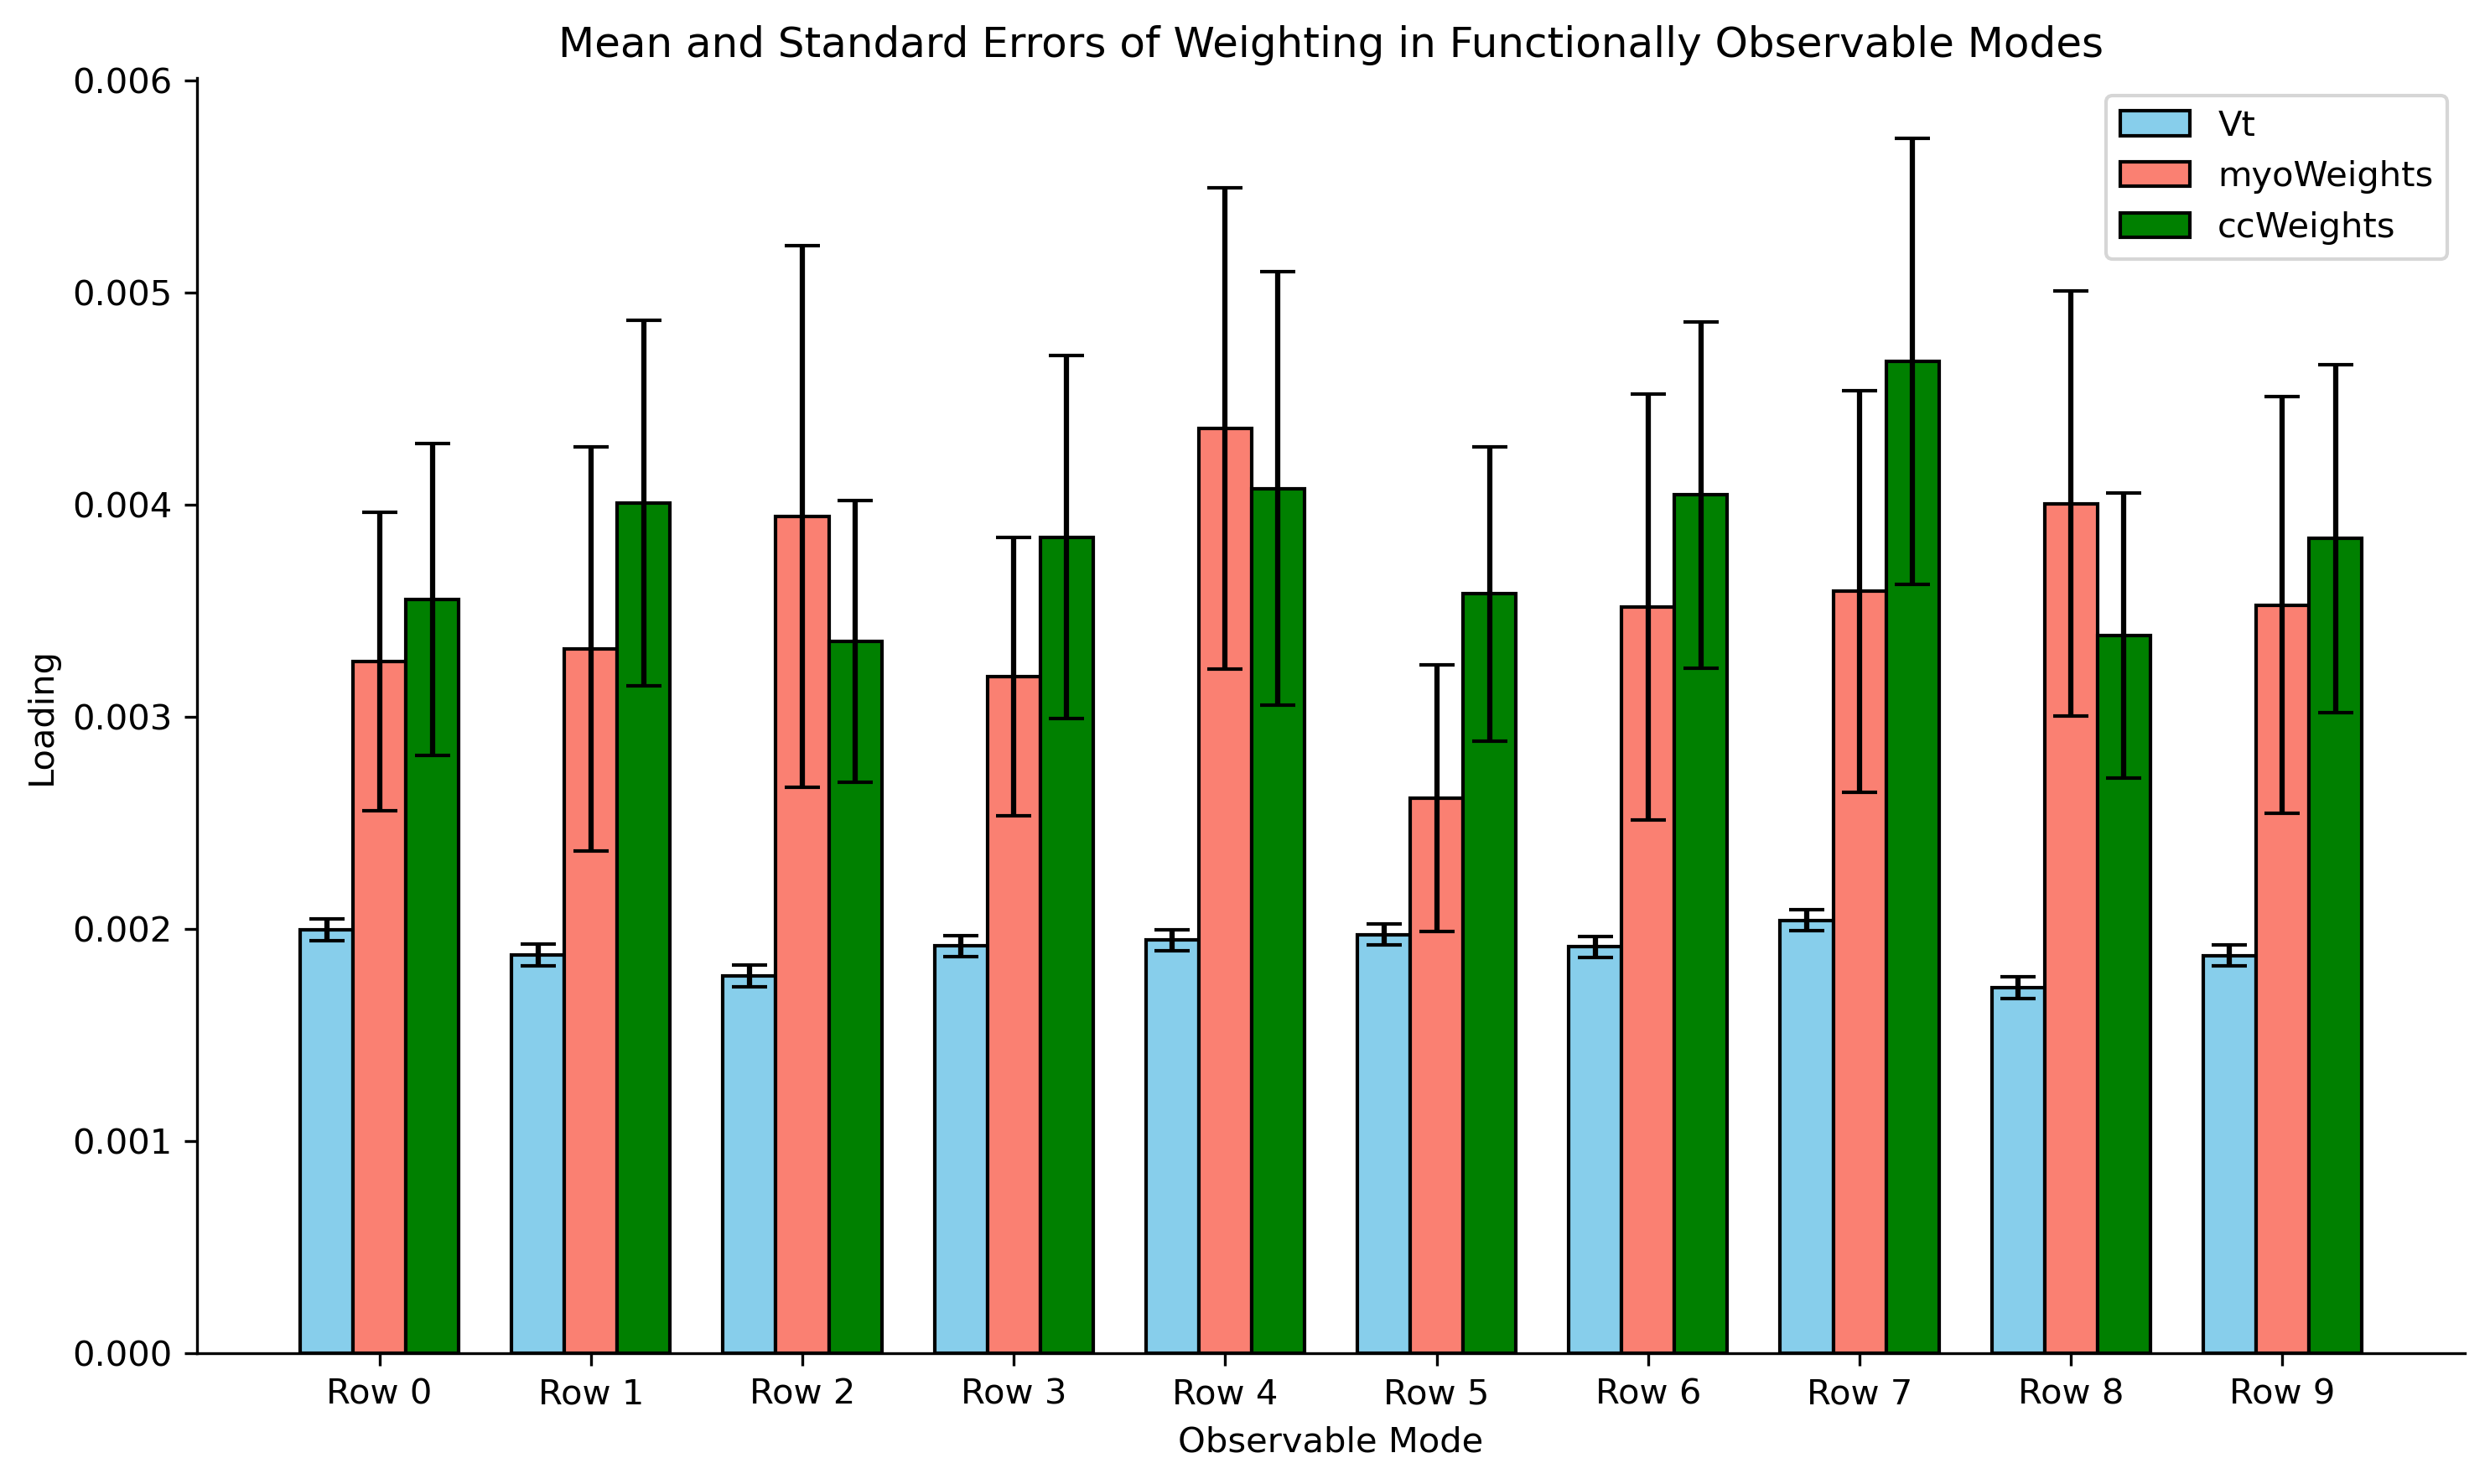

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data from the .csv file
df = pd.read_csv('data/functional_obsv_data-full.csv')

# Extract data for plotting
x = np.arange(len(df))  # x locations for the groups
width = 0.25  # Width of the bars

# Extract means and stds from the DataFrame
Vt_means = df['Vt_means']
Vt_stds = df['Vt_serr']
myo_means = df['myo_means']
myo_stds = df['myo_serr']
cc_means = df['cc_means']
cc_stds = df['cc_serr']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars
bars1 = ax.bar(x - width, Vt_means, width, yerr=Vt_stds, label='Vt', color='skyblue', capsize=5, edgecolor='black')
bars2 = ax.bar(x, myo_means, width, yerr=myo_stds, label='myoWeights', color='salmon', capsize=5, edgecolor='black')
bars3 = ax.bar(x + width, cc_means, width, yerr=cc_stds, label='ccWeights', color='green', capsize=5, edgecolor='black')

# Add labels and title
ax.set_xlabel('Observable Mode')
ax.set_ylabel('Loading')
ax.set_title('Mean and Standard Errors of Weighting in Functionally Observable Modes')
ax.set_xticks(x)
ax.set_xticklabels(df['Row'])
ax.legend()

plt.tight_layout()
sns.despine()
plt.show()


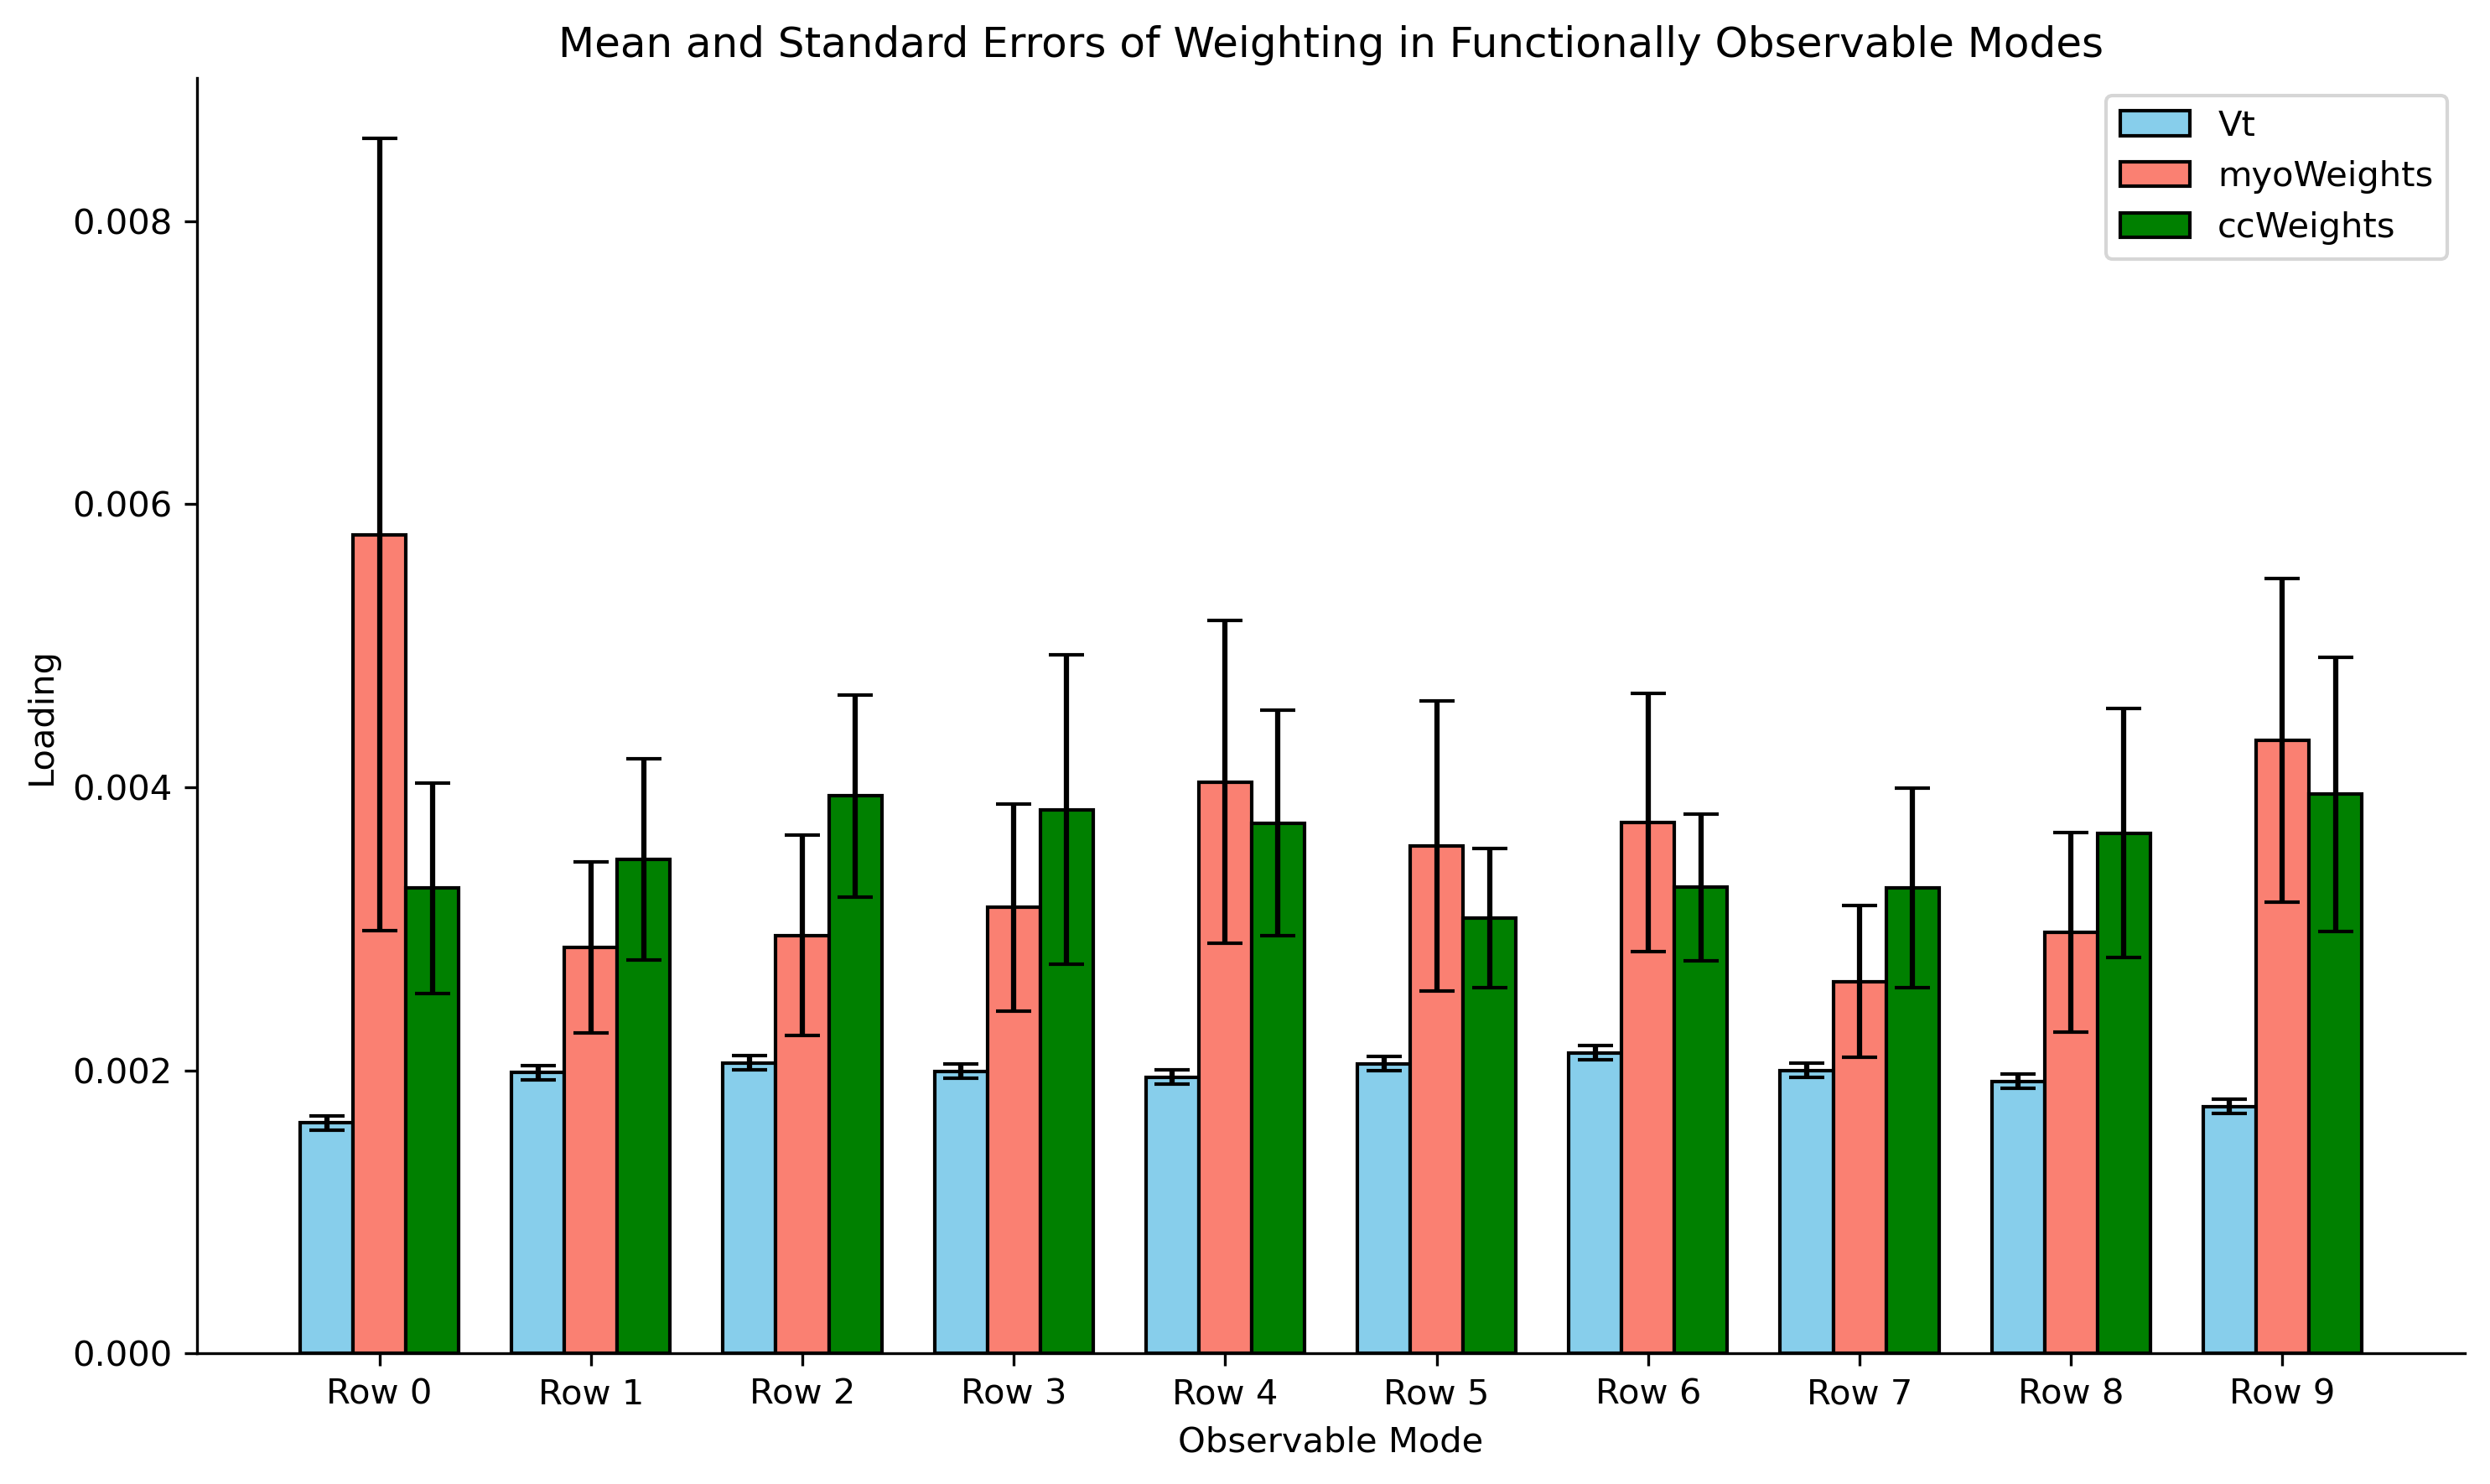

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data from the .csv file
df = pd.read_csv('data/functional_obsv_data-t1.csv')

# Extract data for plotting
x = np.arange(len(df))  # x locations for the groups
width = 0.25  # Width of the bars

# Extract means and stds from the DataFrame
Vt_means = df['Vt_means']
Vt_stds = df['Vt_serr']
myo_means = df['myo_means']
myo_stds = df['myo_serr']
cc_means = df['cc_means']
cc_stds = df['cc_serr']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars
bars1 = ax.bar(x - width, Vt_means, width, yerr=Vt_stds, label='Vt', color='skyblue', capsize=5, edgecolor='black')
bars2 = ax.bar(x, myo_means, width, yerr=myo_stds, label='myoWeights', color='salmon', capsize=5, edgecolor='black')
bars3 = ax.bar(x + width, cc_means, width, yerr=cc_stds, label='ccWeights', color='green', capsize=5, edgecolor='black')

# Add labels and title
ax.set_xlabel('Observable Mode')
ax.set_ylabel('Loading')
ax.set_title('Mean and Standard Errors of Weighting in Functionally Observable Modes')
ax.set_xticks(x)
ax.set_xticklabels(df['Row'])
ax.legend()

plt.tight_layout()
sns.despine()
plt.show()


## Fixed Sensors

### Build Model

In [6]:
model = 'DGC'
LTI = bioObsv.Model.LinearTimeInvariant(data=full2018['TPM'], dmdRank=-1, states=GENES)

fixedSensors = 'Sheet2'
sdf = pd.read_excel(gramianSensorFiles[model], sheet_name=fixedSensors)


### Built OMAT

In [7]:
sdf = sdf.applymap(lambda x: x.strip() if isinstance(x, str) else x)
sensors = list(sdf.iloc[:200].values)
sensorsFiltered = []
for s in sensors:
    if s[0] in myogenicGenes:
        sensorsFiltered.append(s)
len(sensorsFiltered)
# sensors = list(set(myogenicGenes).intersection(set(sensors)))
LTI.setMeasurments(sensorsFiltered)

 /tmp/ipykernel_2722802/1772870310.py:1: FutureWarning:DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [8]:
sensorsFiltered = []
for s in sensors:
    if s[0] in myogenicGenes:
        sensorsFiltered.append(s)
len(sensorsFiltered)

106

In [9]:
O = LTI.obsv(t=10, reduced=True)
print(f"{O.shape=}")
print(f"{O.shape=}")
O = O / O.sum(axis=1, keepdims=1)
O[np.isnan(O)] = 0
O[np.isinf(O)] = 0
print(f"{O.shape=}")

O.shape=(1060, 19235)
O.shape=(1060, 19235)
O.shape=(1060, 19235)


 /tmp/ipykernel_2722802/3484923492.py:4: RuntimeWarning:divide by zero encountered in divide
 /tmp/ipykernel_2722802/3484923492.py:4: RuntimeWarning:invalid value encountered in divide


In [10]:
from scipy.sparse.linalg import svds

# Set k to the number of largest singular values/vectors you want
k = 10  # adjust k as needed

In [11]:
# Compute the largest k singular values and vectors
U, Sigma, Vt = svds(O, k=k)


In [12]:
print(f"{U.shape=}")
print(f"{Sigma.shape=}")
print(f"{Vt.shape=}")

U.shape=(1060, 10)
Sigma.shape=(10,)
Vt.shape=(10, 19235)


In [13]:
masks = np.zeros_like(GENES, dtype=bool)
for i, gene in enumerate(GENES):
    if gene in myogenicGenes:
        masks[i] = True

myoWeights = Vt[:, masks]
print(f"{myoWeights.shape=}")

masks = np.zeros_like(GENES, dtype=bool)
for i, gene in enumerate(GENES):
    if gene in cellCycleGenes:
        masks[i] = True

ccWeights = Vt[:, masks]
print(f"{ccWeights.shape=}")


myoWeights.shape=(10, 206)
ccWeights.shape=(10, 200)


In [14]:
myoWeights = myoWeights # np.log(np.abs(myoWeights))
ccWeights  = ccWeights  # np.log(np.abs(ccWeights))
VtWeights  = Vt         # np.log(np.abs(Vt))

myoWeights[np.isnan(myoWeights)] = 0
ccWeights [np.isnan(ccWeights )] = 0
VtWeights [np.isnan(VtWeights )] = 0
myoWeights[np.isinf(myoWeights) | (myoWeights == -np.inf)] = 0
ccWeights [np.isinf(ccWeights) | (ccWeights == -np.inf)] = 0
VtWeights [np.isinf(VtWeights) | (VtWeights == -np.inf)] = 0


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Pre-allocate arrays to store means and standard deviations for visualization
num_rows = 10  # The number of rows you want to visualize
Vt_means = np.zeros(num_rows)
Vt_stds = np.zeros(num_rows)
myo_means = np.zeros(num_rows)
myo_stds = np.zeros(num_rows)
cc_means = np.zeros(num_rows)
cc_stds = np.zeros(num_rows)

# Calculate mean and standard deviation for each row in Vt and myoWeights
for i in range(num_rows):
    Vt_means[i] = np.mean(np.abs(VtWeights[i, :]))
    myo_means[i] = np.mean(np.abs(myoWeights[i, :]))
    cc_means[i] = np.mean(np.abs(ccWeights[i, :]))
    Vt_stds[i]  = stats.sem(np.abs(VtWeights[i, :]))
    myo_stds[i] = stats.sem(np.abs(myoWeights[i, :]))
    cc_stds[i]  = stats.sem(np.abs(ccWeights[i, :]))
#    Vt_stds[i]  = np.std(np.abs(VtWeights[i, :]))
#    myo_stds[i] = np.std(np.abs(myoWeights[i, :]))
#    cc_stds[i]  = np.std(np.abs(ccWeights[i, :]))

In [16]:
# Create a DataFrame to store all data
data = {
    'Row': [f'Row {i}' for i in range(num_rows)],
    'Vt_means': Vt_means,
    'Vt_serr': Vt_stds,
    'myo_means': myo_means,
    'myo_serr': myo_stds,
    'cc_means': cc_means,
    'cc_serr': cc_stds
}

df = pd.DataFrame(data)
df.to_csv('data/functional_obsv_data.csv', index=False)


In [25]:
# Assuming Vt is a matrix and GENES is a list of gene names
adata = ad.AnnData(X=Vt, var=pd.DataFrame(index=GENES))

# Export as a CSV
adata.to_df().to_csv("data/functional_obsv_modes.csv", index=False)

# Load output data and make plots

## Mode Weights

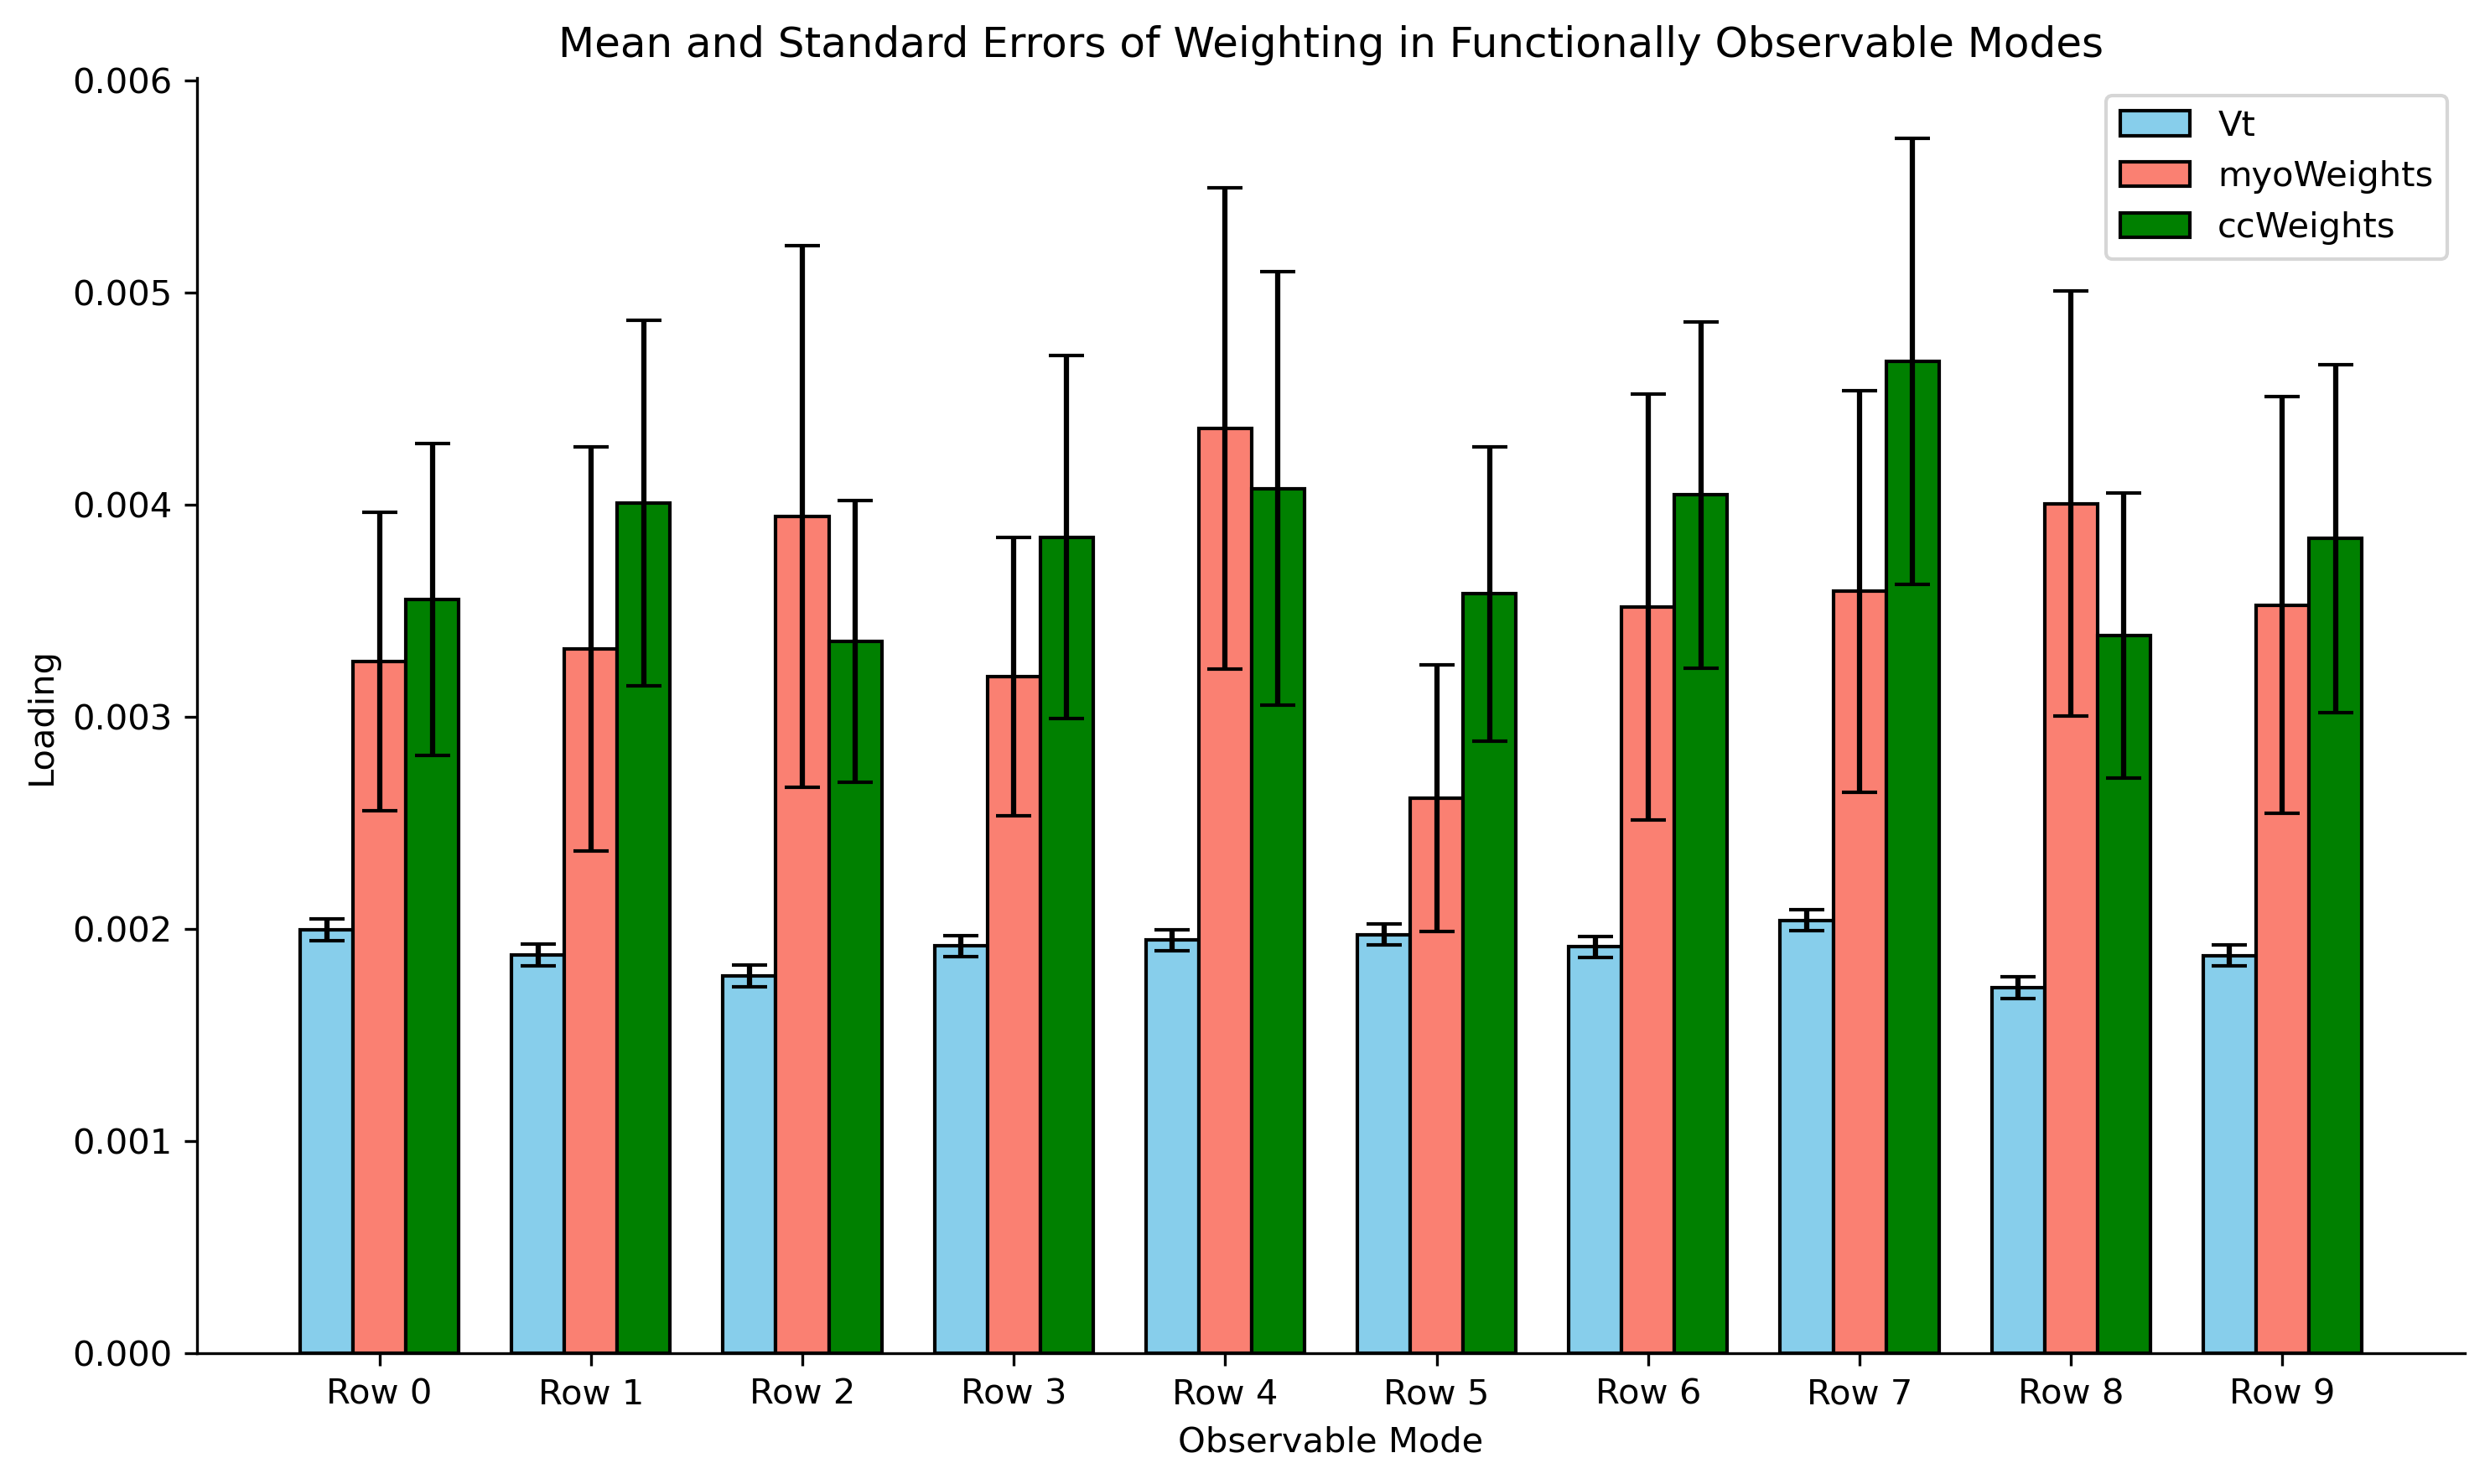

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load data from the .csv file
df = pd.read_csv('data/functional_obsv_data.csv')

# Extract data for plotting
x = np.arange(len(df))  # x locations for the groups
width = 0.25  # Width of the bars

# Extract means and stds from the DataFrame
Vt_means = df['Vt_means']
Vt_stds = df['Vt_serr']
myo_means = df['myo_means']
myo_stds = df['myo_serr']
cc_means = df['cc_means']
cc_stds = df['cc_serr']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars
bars1 = ax.bar(x - width, Vt_means, width, yerr=Vt_stds, label='Vt', color='skyblue', capsize=5, edgecolor='black')
bars2 = ax.bar(x, myo_means, width, yerr=myo_stds, label='myoWeights', color='salmon', capsize=5, edgecolor='black')
bars3 = ax.bar(x + width, cc_means, width, yerr=cc_stds, label='ccWeights', color='green', capsize=5, edgecolor='black')

# Add labels and title
ax.set_xlabel('Observable Mode')
ax.set_ylabel('Loading')
ax.set_title('Mean and Standard Errors of Weighting in Functionally Observable Modes')
ax.set_xticks(x)
ax.set_xticklabels(df['Row'])
ax.legend()

plt.tight_layout()
sns.despine()
plt.show()


In [34]:
import anndata as ad
import pandas as pd
import gget

df = pd.read_csv("data/functional_obsv_modes.csv").T
df

0         1         2         3         4         5         6  \
A1BG    -0.000122 -0.001252 -0.000684 -0.000969 -0.001671  0.001598 -0.001354   
A1CF    -0.000043 -0.000003  0.000013 -0.000019 -0.000024 -0.000002  0.000001   
A2M     -0.004096 -0.008896  0.001013 -0.002299  0.002175 -0.006668 -0.001130   
A2ML1   -0.000015  0.000019 -0.000016 -0.000036 -0.000028 -0.000059  0.000015   
A3GALT2 -0.000368  0.000116  0.000038  0.000060  0.000118  0.000039  0.000080   
...           ...       ...       ...       ...       ...       ...       ...   
ZYG11A   0.000283  0.000327  0.000079  0.000056  0.000380 -0.000120 -0.000055   
ZYG11B  -0.000903  0.000637 -0.000237 -0.000626  0.001535 -0.001316  0.001053   
ZYX      0.006905 -0.012354  0.003705 -0.020163  0.022783 -0.018957  0.032026   
ZZEF1    0.000616  0.000657 -0.000370 -0.000211  0.000675  0.000093  0.000637   
ZZZ3     0.000495 -0.000164 -0.000065 -0.000317  0.000496 -0.000094 -0.001623   

                7         8         9  
A1BG     0.000389  0.000193 -0.000597  
A1CF     0.000019 -0.000034 -0.000008  
A2M      0.006013 -0.007989 -0.001095  
A2ML1    0.000011  0.000001  0.000061  
A3GALT2  0.000098  0.000046  0.000069  
...           ...       ...       ...  
ZYG11A  -0.000174 -0.000103 -0.000001  
ZYG11B  -0.000126  0.000228  0.000175  
ZYX      0.000992  0.014569  0.016865  
ZZEF1   -0.000536 -0.000759 -0.000597  
ZZZ3    -0.000157  0.000881  0.000056  

[19235 rows x 10 columns]

In [35]:
top_genes = df.nlargest(10, df.columns[0]).index
top_genes

Index(['SH3BGRL3', 'RHOB', 'SERPINE1', 'MMP3', 'GREM1', 'CAVIN3', 'FN1',
       'CCN1', 'CXCL2', 'NACA2'],
      dtype='object')

In [60]:
# db = 'GO_Biological_Process_2021'
db = 'PanglaoDB_Augmented_2021'
numGenes = 1000

top_genes = df.nlargest(numGenes, df.columns[0]).index
top_genes

edf = gget.enrichr(top_genes, database=db)
edf['numOverlap'] = edf['overlapping_genes'].apply(len)
edf['name'] = edf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
edf['name'][:50]

15:07:11 - INFO - Performing Enichr analysis using database PanglaoDB_Augmented_2021.


0                                  Myoblasts
1                                Fibroblasts
2                 Airway smooth muscle cells
3                  Pancreatic stellate cells
4                            Granulosa cells
5                                 Osteocytes
6                     Hepatic stellate cells
7                             Myofibroblasts
8                        Smooth muscle cells
9                            Microfold cells
10                Adipocyte progenitor cells
11                        Endothelial cells 
12          Cardiac stem and precursor cells
13                           Satellite cells
14                               Osteoblasts
15                 Undefined placental cells
16                         Mesothelial cells
17                   Peritubular myoid cells
18                               Melanocytes
19                                 Podocytes
20              Trophoblast progenitor cells
21                                 Pericytes
22        

In [63]:
edf[:6]

rank                   path_name         p_val   z_score  combined_score  \
0     1                   Myoblasts  5.643691e-10  5.045175      107.438569   
1     2                 Fibroblasts  5.019988e-09  3.461797       66.154389   
2     3  Airway Smooth Muscle Cells  7.877385e-08  4.887884       79.949582   
3     4   Pancreatic Stellate Cells  1.231436e-07  4.506980       71.705667   
4     5             Granulosa Cells  1.445210e-07  4.457217       70.200459   
5     6                  Osteocytes  3.267222e-07  4.638757       69.275913   

                                   overlapping_genes     adj_p_val  \
0  [HSPB6, COL12A1, HSPB7, CXCL1, RND3, TMEM47, G...  8.183352e-08   
1  [SPARC, HSPB6, ELN, COL12A1, THY1, CXCL3, HIF1...  3.639491e-07   
2  [FOXC2, HSPB6, FOXF1, LUM, TGFB1I1, COL12A1, T...  3.807403e-06   
3  [SPARC, HSPB6, LUM, COL12A1, FN1, BGN, THY1, K...  4.191109e-06   
4  [FZD7, COL12A1, GPX8, FOXL2, RND3, LARP6, EHD2...  4.191109e-06   
5  [FZD7, TPBG, TPM1, WNT5A, GPX8, PLAT, RND3, CN...  7.895787e-06   

                   database  numOverlap                        name  
0  PanglaoDB_Augmented_2021          26                   Myoblasts  
1  PanglaoDB_Augmented_2021          35                 Fibroblasts  
2  PanglaoDB_Augmented_2021          20  Airway smooth muscle cells  
3  PanglaoDB_Augmented_2021          21   Pancreatic stellate cells  
4  PanglaoDB_Augmented_2021          21             Granulosa cells  
5  PanglaoDB_Augmented_2021          19                  Osteocytes

# Scratch

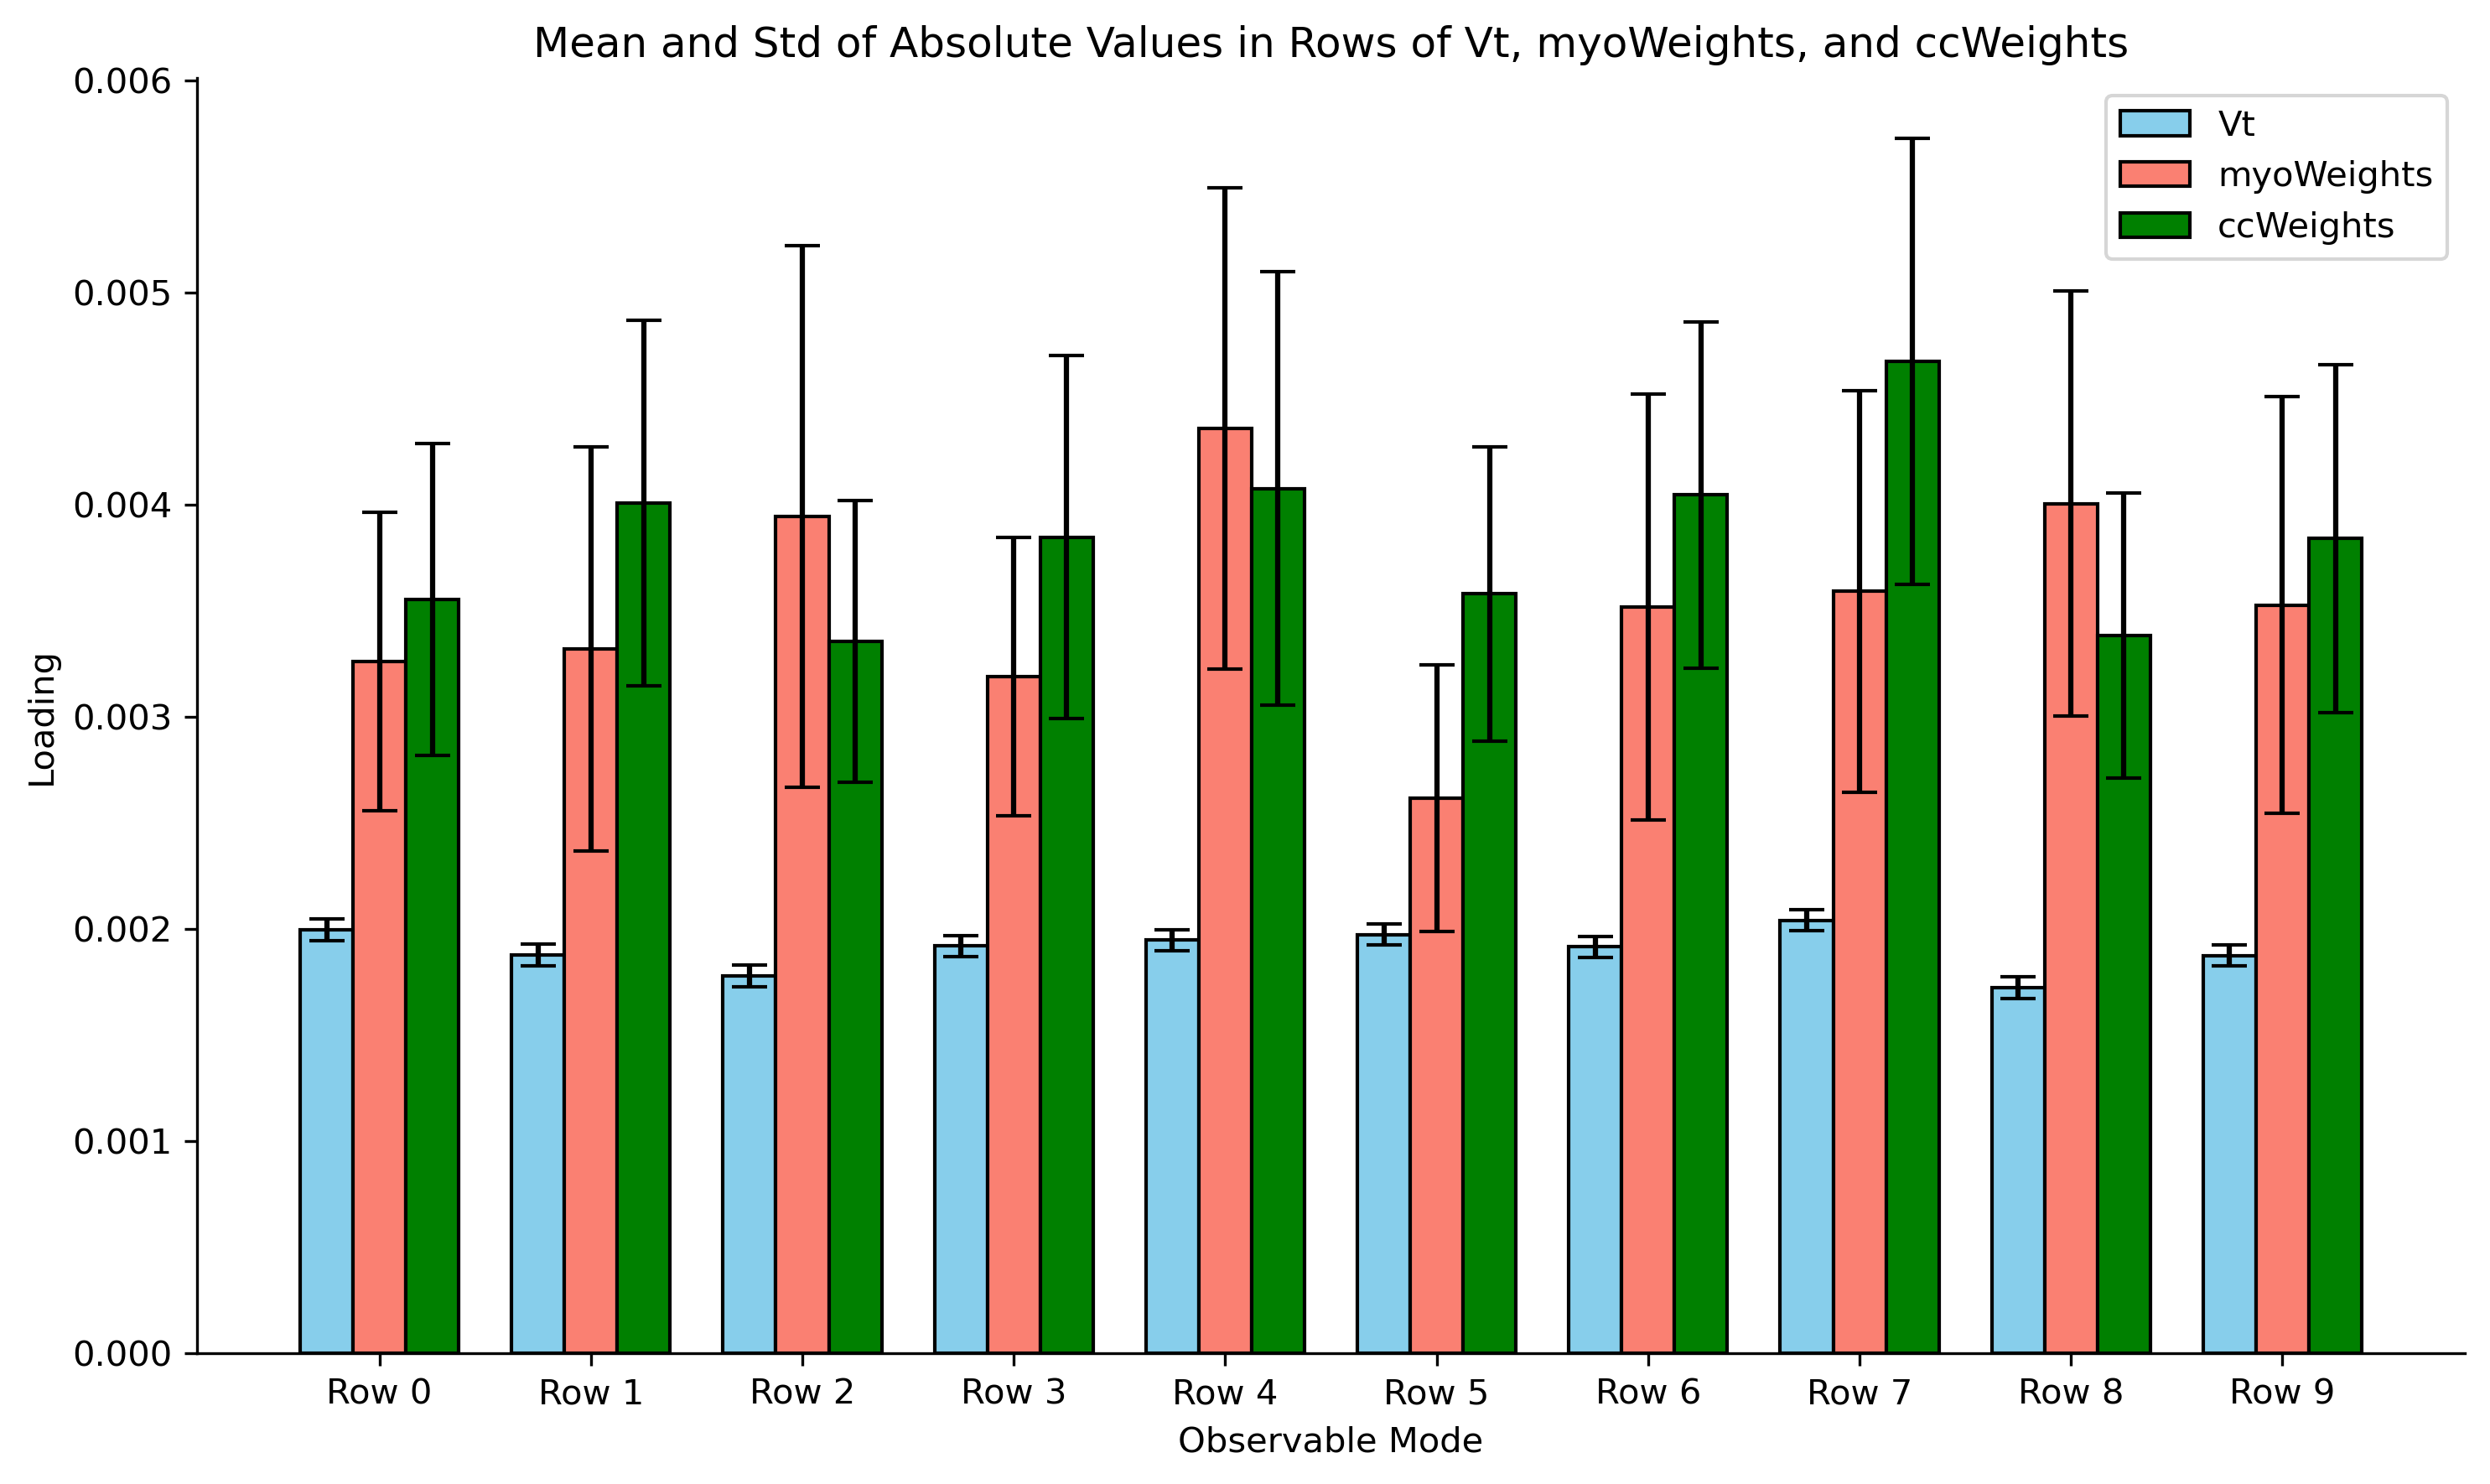

In [17]:
# Plot the data
x = np.arange(num_rows)  # x locations for the groups
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for means with error bars for stds
bars1 = ax.bar(x - width, Vt_means, width, yerr=Vt_stds, label='Vt', color='skyblue', capsize=5, edgecolor='black')
bars2 = ax.bar(x, myo_means, width, yerr=myo_stds, label='myoWeights', color='salmon', capsize=5, edgecolor='black')
bars3 = ax.bar(x + width, cc_means, width, yerr=cc_stds, label='ccWeights', color='green', capsize=5, edgecolor='black')

# Add labels and title
ax.set_xlabel('Observable Mode')
ax.set_ylabel('Loading')
ax.set_title('Mean and Std of Absolute Values in Rows of Vt, myoWeights, and ccWeights')
ax.set_xticks(x)
ax.set_xticklabels([f'Row {i}' for i in range(num_rows)])
ax.legend()

plt.tight_layout()
sns.despine()
plt.show()


(array([ 2.,  1.,  2.,  2.,  2.,  6., 15., 14., 16., 33., 38., 50., 54.,
        56., 74., 73., 67., 79., 76., 77., 73., 52., 44., 33., 28., 17.,
        15.,  6.,  6.,  9.]),
 array([-16.65894844, -16.16676912, -15.6745898 , -15.18241048,
        -14.69023116, -14.19805185, -13.70587253, -13.21369321,
        -12.72151389, -12.22933457, -11.73715525, -11.24497593,
        -10.75279661, -10.26061729,  -9.76843797,  -9.27625866,
         -8.78407934,  -8.29190002,  -7.7997207 ,  -7.30754138,
         -6.81536206,  -6.32318274,  -5.83100342,  -5.3388241 ,
         -4.84664478,  -4.35446547,  -3.86228615,  -3.37010683,
         -2.87792751,  -2.38574819,  -1.89356887]),
 <BarContainer object of 30 artists>)

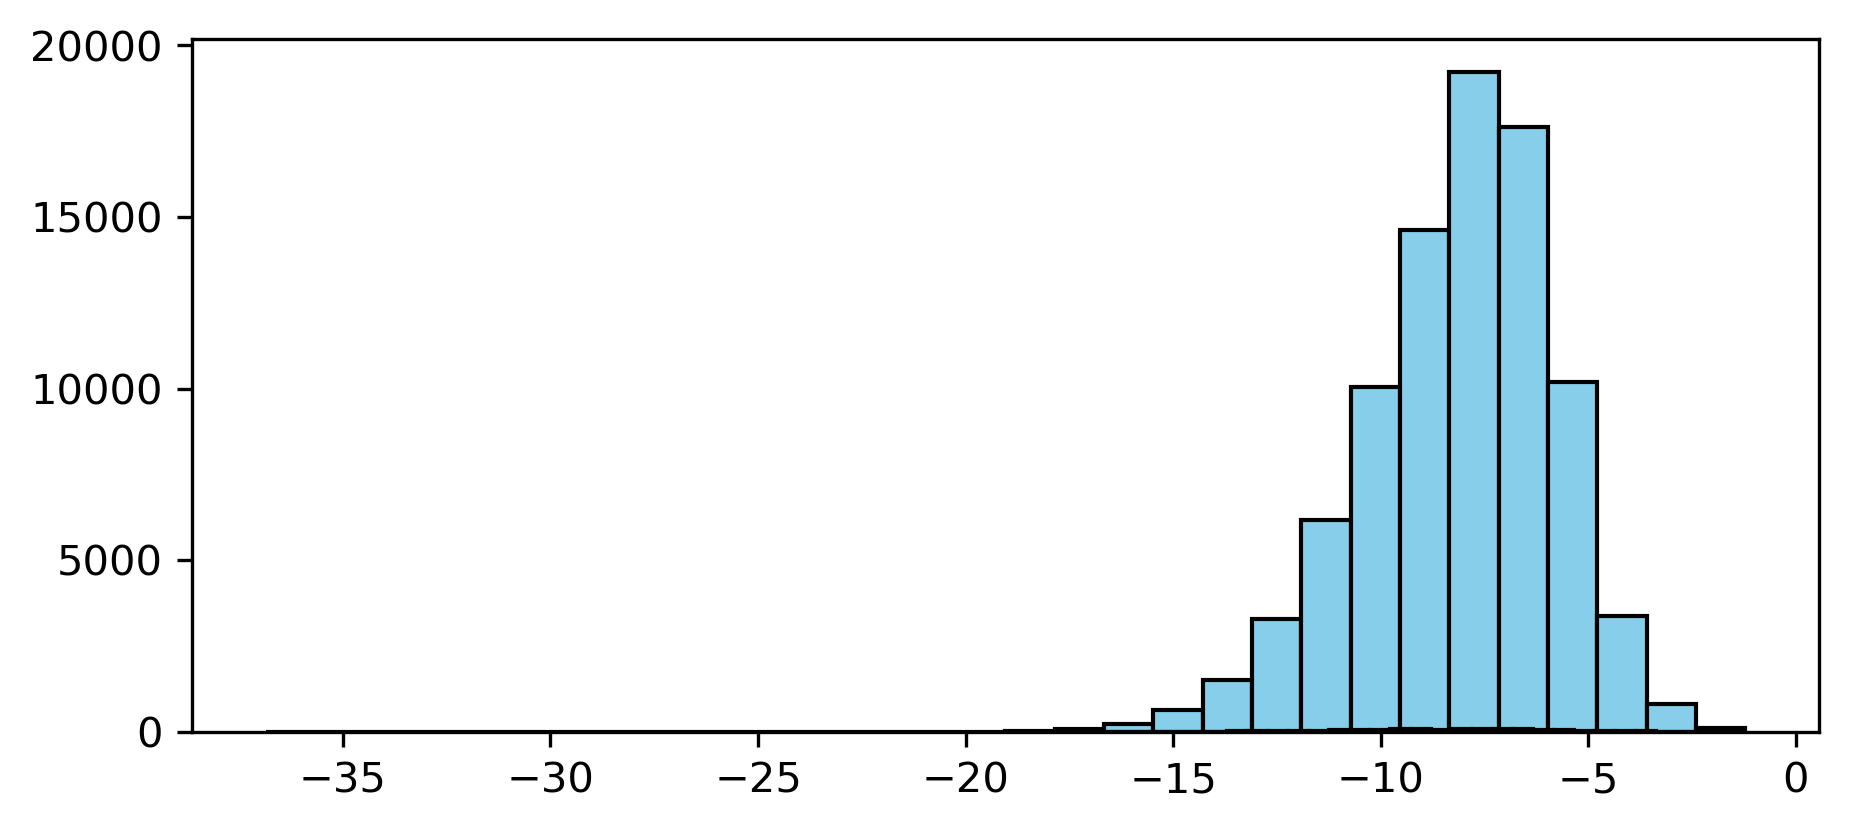

In [193]:
XX = Vt.flatten()
XX[np.isnan(XX)] = 0
XX[np.isinf(XX) | (XX == -np.inf)] = 0  # Filters out both positive and negative infinity
plt.hist(np.log(XX[XX > 0]), bins=30, color='skyblue', edgecolor='black')  # Filters out non-positive values before log
XX = myoWeights.flatten()
XX[np.isnan(XX)] = 0
XX[np.isinf(XX) | (XX == -np.inf)] = 0  # Filters out both positive and negative infinity
plt.hist(np.log(XX[XX > 0]), bins=30, edgecolor='black')  # Filters out non-positive values before log



 /tmp/ipykernel_1695347/1921489174.py:4: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_1695347/1921489174.py:4: RuntimeWarning:invalid value encountered in log


ValueError: supplied range of [-inf, -1.2222647230169206] is not finite

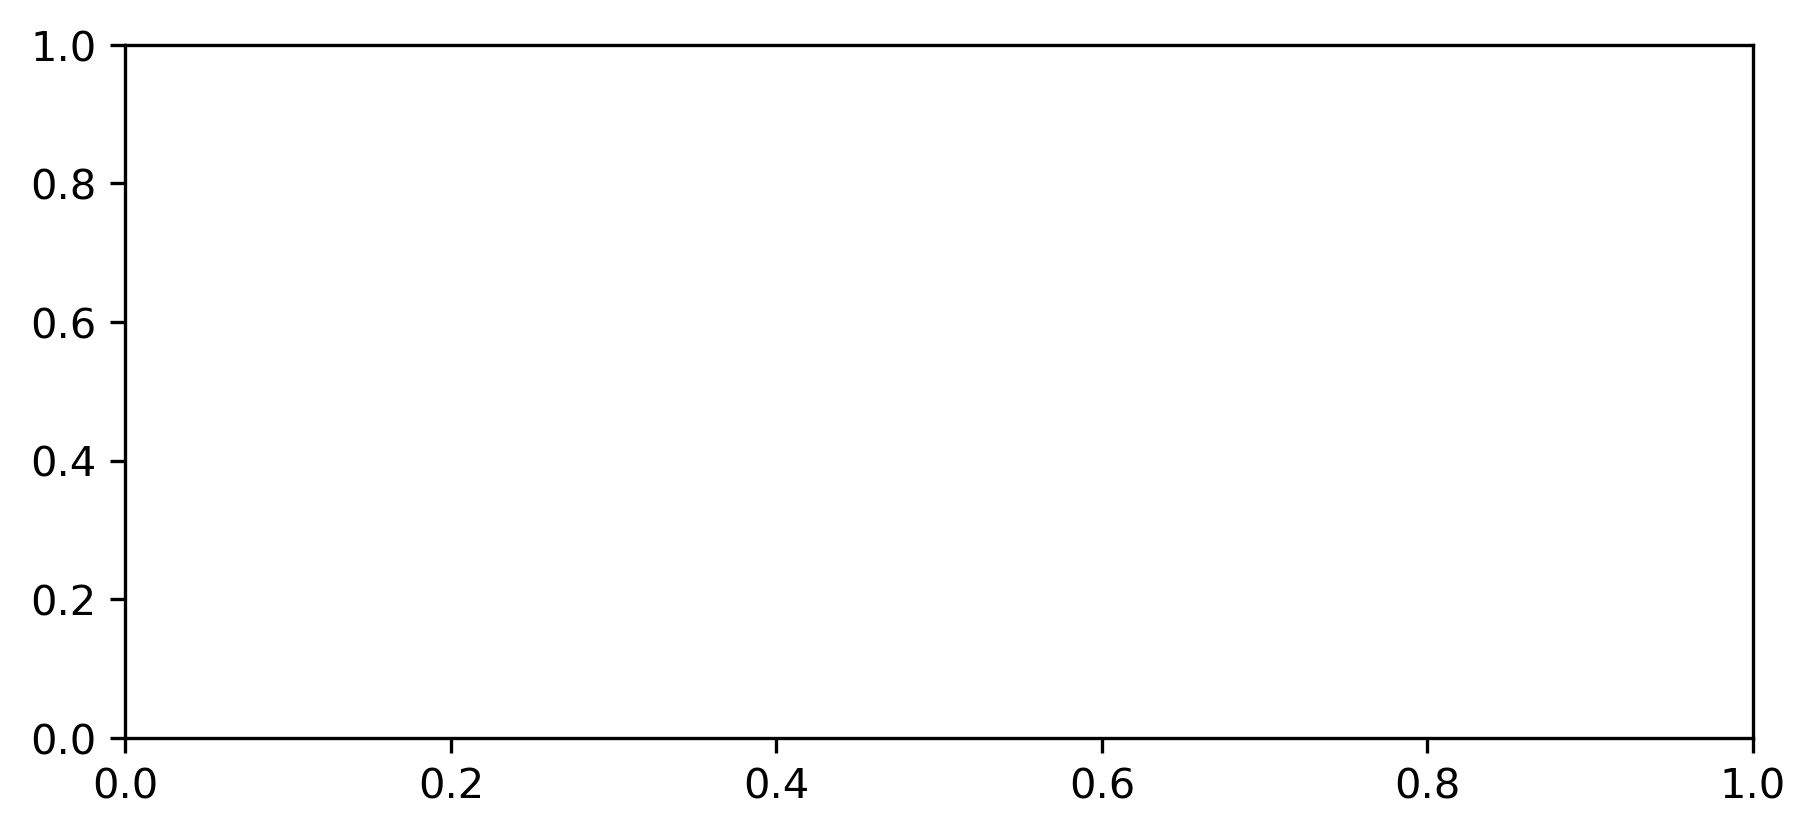

In [181]:
XX = Vt.flatten()
XX[np.isnan(XX)] = 0
XX[np.isinf(np.abs(XX))] = 0
plt.hist(np.log(XX), bins=30, color='skyblue', edgecolor='black')

CC=[16, 15, 18, 15, 17, 23, 22, 19, 15, 14]


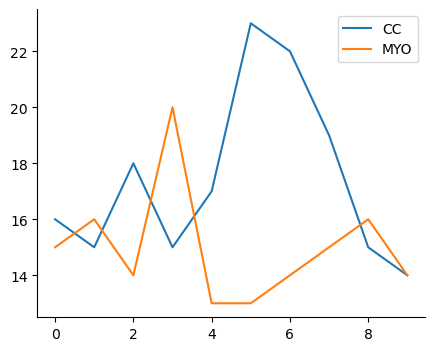

In [170]:
thresh = 0.5
k = 1000
CC, MYO, OTHER = [], [], []
for i in range(10):
    V = np.abs(Vt[i,:])
    masks = np.zeros_like(V, dtype=bool)
    masks = (V > (np.mean(V) + np.std(V)))
#    top_k_indices = np.argsort(V)[-k:]
#    masks[top_k_indices] = True

    cc, myo, other = 0, 0, 0
    for j in range(len(masks)):
        if masks[j] == False:
            continue
        if GENES[j] in cellCycleGenes:
            cc += 1
        elif GENES[j] in myogenicGenes:
            myo += 1
        else:
            other += 1
    # print(f"{sum(masks)=}")
    CC.append(cc)
    MYO.append(myo)
    OTHER.append(other)

print(f"{CC=}")
plt.figure(figsize=(5,4), dpi=100)
plt.plot(CC, label='CC')
plt.plot(MYO, label='MYO')
# plt.plot(OTHER, label='OTHER')
sns.despine()
plt.legend()

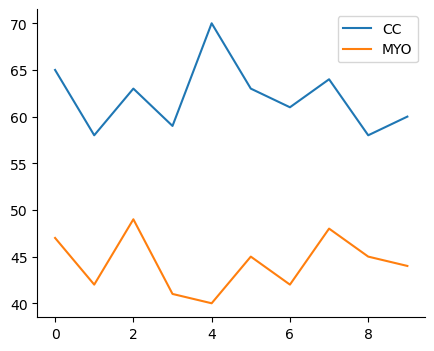

In [130]:
plt.figure(figsize=(5,4), dpi=100)
plt.plot(CC, label='CC')
plt.plot(MYO, label='MYO')
sns.despine()
plt.legend()

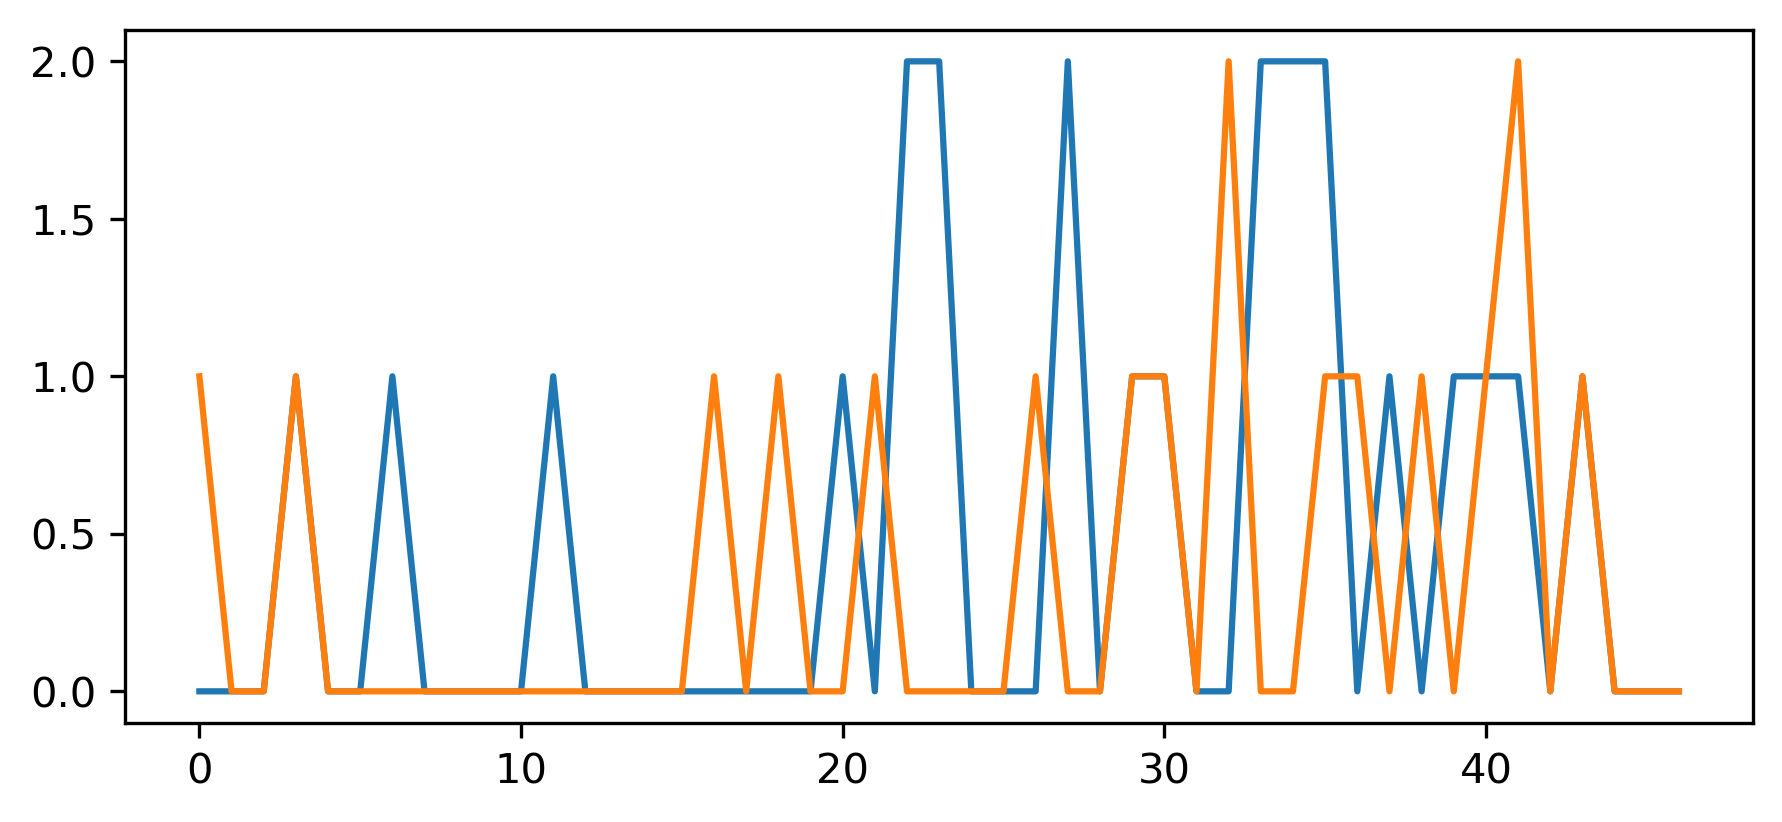

In [78]:
plt.plot(CC)
plt.plot(MYO)

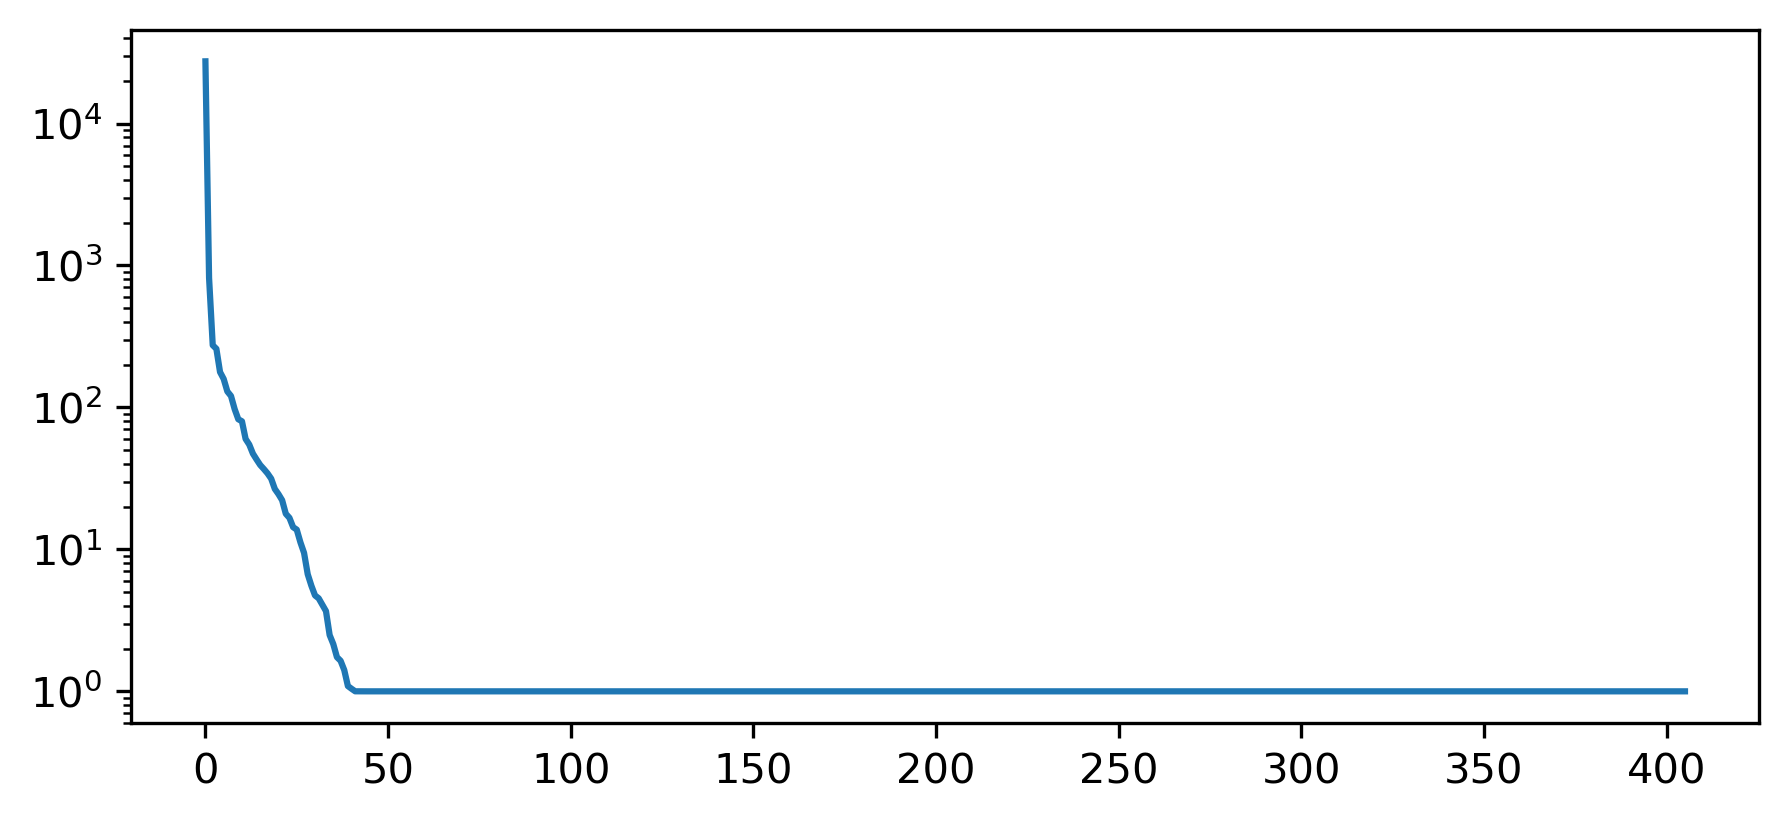

In [58]:
plt.plot(Sigma)
plt.yscale('log')

In [18]:
sum(sum(LTI.output['C'].toarray()))

406.0

In [15]:
np.linalg.matrix_rank(O)

42

In [94]:
# nSensors
sensorType = 'fixed'
sdf = sdf.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Omats = {}
for nSensors in range(5,407, 5):
    if nSensors % 25 == 0:
        print(nSensors)
    sensors = list(sdf.iloc[:nSensors].values)
    LTI.setMeasurments(sensors)
    O = LTI.obsv(t=25, reduced=True)
    Omats[nSensors] = O
    
    # rank = np.linalg.matrix_rank(O)

 /tmp/ipykernel_2408723/1310403054.py:3: FutureWarning:DataFrame.applymap has been deprecated. Use DataFrame.map instead.


25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400


In [ ]:
sensors = []
sigmas  = []
rank    = []
effectiveRank = []
modes   = []
for nSensors in range(5,407, 5):
    U, sigma, V = np.linalg.SVD(Omats[nSensors])

In [105]:
O = Omats[5]
U, sigma, V = sp.linalg.svd(O)
print(f"{O.shape=}")
print(f"{U.shape=}")
print(f"{sigma.shape=}")
print(f"{V.shape=}")


O.shape=(125, 406)
U.shape=(125, 125)
sigma.shape=(125,)
V.shape=(406, 406)


In [119]:
sum(sum(O - (U @ np.diag(sigma) @ V[:125,:])))

0.0010624758139608287

In [90]:
O = LTI.obsv(t=3, reduced=True)
rank = np.linalg.matrix_rank(O)

print(f"{O.shape=}")
print(f"{rank=}")

O.shape=(3, 406)
rank=3


In [82]:
sum(sum(O))

0.0

In [53]:
OF = np.vstack((O, F))
np.linalg.matrix_rank(OF)

47

In [54]:
O.shape

(1400, 406)

In [41]:
""" get marker genes """

def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]        
    return genes['official gene symbol'].to_list()

""" Load the marker gene database """
pdfPath = "/home/jpic/bioObsv/notebooks/obsvArticle2/data/PanglaoDB_markers_27_Mar_2020.tsv.gz"
pang_df = pd.read_csv(pdfPath, sep="\t")
pang_df.head()

""" UI """
U = 0.05

# xtract gene lists    
fbList = getGenes(pang_df, 'Fibroblasts', ui_upper=U)

mg_cells = ['Myoblasts', 'Myofibroblasts', 'Myocytes', 'Cardiomyocytes', 'Myoepithelial cells', 'Myofibroblasts', 'Airway smooth muscle cells']
myList = []

for mg in mg_cells:
    myList += getGenes(pang_df, mg, ui_upper=U)

myogenicGenes = list(set(myList))
print(f"{len(myogenicGenes)=}")

cellCycleF = np.zeros(406,)
reprogramF = np.zeros(406,)

for i, gene in enumerate(reduced2018['genes']):
    if gene in myogenicGenes:
        reprogramF[i] = 1
    else:
        cellCycleF[i] = 1

print(f"{sum(cellCycleF)=}")
print(f"{sum(reprogramF)=}")

len(myogenicGenes)=212
sum(cellCycleF)=200.0
sum(reprogramF)=206.0


In [39]:
cellCycleF = np.zeros(406,)
reprogramF = np.zeros(406,)

for i, gene in enumerate(reduced2018['genes']):
    if gene in myogenicGenes:
        reprogramF[i] = 1
    else:
        cellCycleF[i] = 1

Help on _ArrayFunctionDispatcher in module numpy.linalg:

matrix_rank(A, tol=None, hermitian=False)
    Return matrix rank of array using SVD method
    
    Rank of the array is the number of singular values of the array that are
    greater than `tol`.
    
    .. versionchanged:: 1.14
       Can now operate on stacks of matrices
    
    Parameters
    ----------
    A : {(M,), (..., M, N)} array_like
        Input vector or stack of matrices.
    tol : (...) array_like, float, optional
        Threshold below which SVD values are considered zero. If `tol` is
        None, and ``S`` is an array with singular values for `M`, and
        ``eps`` is the epsilon value for datatype of ``S``, then `tol` is
        set to ``S.max() * max(M, N) * eps``.
    
        .. versionchanged:: 1.14
           Broadcasted against the stack of matrices
    hermitian : bool, optional
        If True, `A` is assumed to be Hermitian (symmetric if real-valued),
        enabling a more efficient method fo

In [13]:
help(LTV)

Help on LinearTimeVariant in module scr.Model object:

class LinearTimeVariant(Model)
 |  LinearTimeVariant(times=None, data=None, states=None, dmdRanks=None, LTIs=None, debug=False, reduced=True, u_r=None)
 |  
 |  Linear Time-Variant (LTV) model class
 |  
 |  Args:
 |      Model (_type_): _description_
 |  
 |  Raises:
 |      ValueError: _description_
 |  
 |  Returns:
 |      _type_: _description_
 |  
 |  Method resolution order:
 |      LinearTimeVariant
 |      Model
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, times=None, data=None, states=None, dmdRanks=None, LTIs=None, debug=False, reduced=True, u_r=None)
 |      _summary_
 |      
 |      Args:
 |          data (ndarray, optional): time series data. Defaults to None.
 |          models (dict, optional): dictionary of models at each time. Defaults to None.
 |          states (list, optional): list of states. Defaults to None.
 |          times (list, optional): list of time ranges where a si

In [ ]:
LTV = bioObsv.Model.LinearTimeVariant(data=reduced2018['TPM'], times=None, dmdRanks=[-1], states=reduced2018['genes'])

In [ ]:
models      = ['DMD', 'DGC']
methods     = ['energy', 'gramian']
sensorTypes = ['fixed', 'dynamic']
numSensors  = [3, 5, 7, 10, 25, 50, 75, 100, 150, 200]
predTimes = [13]
res1 = {
#    'data'      :[],
    'model'     :[],
    'sensorType':[],
    'numSensors':[],
    'method'    :[],
    'replicate' :[],
    'Norm'      :[],
    'MSE'       :[],
    'mean % error':[],
    'median % error':[]
}
res2 = {
#    'data'      :[],
    'state'     :[],
    'nSensors'  :[],
    '% error'   :[],
    'method'    :[],
    'replicate' :[],
    'sensorType':[],
    'model'     :[]
}

# DMD v DGC
for model in models:
    print(model)
    Xtest = reduced2018['TPM']
    x0 = Xtest[:,0,:]
    X = np.mean(Xtest, axis=2)
    if model == 'DMD':
        LTV = bioObsv.Model.LinearTimeVariant(data=X, times=[0, 15], dmdRanks=[-1], states=reduced2018['genes'])
        t0, t1 = 0, 15
        for t0p in range(t0+1, t1):
            LTV.LTI[t0p] = bioObsv.Model.LinearTimeInvariant(states=reduced2018['genes'])
            LTV.LTI[t0p].dmd_res['Atilde'] = LTV.LTI[t0].dmd_res['Atilde']
            LTV.LTI[t0p].dmd_res['u_r'] = LTV.LTI[t0].dmd_res['u_r']
            LTV.LTI[t0p].f = {}
            LTV.LTI[t0p].f['A'] = LTV.LTI[t0].f['A']
    else:
        LTV = bioObsv.Model.LinearTimeVariant(data=X, times=None, dmdRanks=[-1], states=reduced2018['genes'])
    X = X[:,:,np.newaxis]
    # Energy v Gramian
    for method in methods:
        print(method)
        # Fixed v. Dynamic
        for sensorType in sensorTypes:
            print(sensorType)
            if method == 'gramian':
                sheet = 'Sheet2'
                if sensorType == 'dynamic':
                    sheet = 'Sheet1'
                sdf = pd.read_excel(gramianSensorFiles[model], sheet_name=sheet)
            elif method == 'energy':
                if sensorType == 'dynamic':
                    sensorEnergySelectionTimes = np.arange(X.shape[1])
                    TVSensors = bioObsv.sensorSelection.energyMaximizationTV(LTV, sensorEnergySelectionTimes, v=False)
                    organizeEnergySensors = {}
                    for i in TVSensors.keys():
                        organizeEnergySensors[i] = TVSensors[i]['sensors']['state'].values
                    sdf = pd.DataFrame(organizeEnergySensors)
                elif sensorType == 'fixed':
                    sensorEnergySelectionTimes = np.arange(X.shape[1])
                    TVSensors = bioObsv.sensorSelection.obsvEnergyMaximization(LTV)
                    organizeEnergySensors = {}
                    # for i in range(1): #len(LTV.LTI.keys())):
                    organizeEnergySensors[0] = TVSensors['sensors']['state'].values
                    sdf = pd.DataFrame(organizeEnergySensors)
                    # print(sdf)
            sdf = sdf.applymap(lambda x: x.strip() if isinstance(x, str) else x)
                    
            resNumSensors = {}
            # number of sensors
            for nSensors in numSensors:
                print(nSensors)
                sensors = {}
                for t in range(len(LTV.LTI)):
                    if sensorType == 'dynamic':
                        sensors[t] = list(sdf.iloc[:nSensors,t].values)
                    else:
                        sensors[t] = list(sdf.iloc[:nSensors].values)
                LTV.setMeasurments(sensors)
                for t in range(len(LTV.LTI)):
                    LTV.LTI[t].output['C'] = LTV.LTI[t].output['C'].toarray()
                O = LTV.obsv(t=predTimes[0]+1, reduced=True)
                x0e = leastSquaresX0new(LTV, Xtest, v=False, O=O, times=predTimes)
                x0e = x0e[:,predTimes[0],:]
                for r in range(x0.shape[1]):
                    e = np.linalg.norm(x0[:,r] - x0e[:,r])
                    mse = mean_squared_error(x0[:,r], x0e[:,r])
                    percent_change = abs((((x0[:,r]+1) - (x0e[:,r]+1)) / (x0[:,r]+1)) * 100)
                    res1['numSensors'].append(nSensors)
                    res1['model'].append(model)
                    res1['method'].append(method)
                    res1['sensorType'].append(sensorType)
                    res1['replicate'].append(r)
                    res1['Norm'].append(e)
                    res1['MSE'].append(mse)
                    res1['mean % error'].append(np.mean(percent_change))
                    res1['median % error'].append(np.median(percent_change))
                    for i in range(len(percent_change)):
                        res2['model'].append(model)
                        res2['state'].append(i)
                        res2['% error'].append(percent_change[i])
                        res2['method'].append(method)
                        res2['replicate'].append(r)
                        res2['nSensors'].append(nSensors)

                        res2['sensorType'].append(sensorType)